# Notebook for pmag data compilation and analyses for the Cardenas Basalt and Unkar Intrusions 

During the April 2021 Grand Canyon Field Syposium, we collected paleomagnetic block samples from the Cardenas Basalt and the Unkar Intrusions and conducted paleomagnetic experiment on core specimens that were later drilled from the block samples in the lab. 

## Block sample preparation description

A total of 18 Cardenas Basalt (CB) sites, 1 interflow sediment (CBS) site, and 5 Unkar Intrusion (UI) sites were sampled during the field syposium. A total of 192 blocks were sampled but block CBS1-8 (an interflow sediment block) went missing duirng shipping. 

Block sampling was done with both magnetic brunton compass (that has magnetic declination set as 0 both in the field and in lab and we perform declination correction later) as well as a sun compass. An oriented flat surface on each block is used as the marker for the outcrop orientation and the block are later drilled in the lab with water-cooled drill press for standard 2.5 cm pmag cores. Then the block in lab are reoriented back to their outcrop orientation and the cores are then oriented with a pomery fixture. 

Because the sun compass orientations are matched with the brunton compass strike measurement (**mag_strike**) on block surface, not the core plate, we do not have sun orientations for the actually cores, but only the magnetic core plate strike orientations. However, the sun compass is still preferentially used for correcting the orientation of blocks when collecting the drilled cores. We use the make_sam_file.py in our SAM_header repository to calculate the expected magnetic declination given the sun compass measurement (*sun_core_strike (in this case it is for block surface not core plate)*) and compare the difference with the magnetic declination reading (**calualted_mag_dec**). Usually the *calualted_mag_dec* match very closely with the *IGRF_local_dec*. Thus for all block reorienting, we preferentially use **sun_core_strike** when we have sun reading, or we use **mag_strike + IGRF_local_dec** for the block orientations. 


## import Python packages

In [1]:
import pandas as pd
import pmagpy.ipmag as ipmag
import pmagpy.pmag as pmag
import matplotlib
import matplotlib.colors as colors
import matplotlib.pyplot as plt
import numpy as np
from IPython.display import display
%config InlineBackend.figure_format='retina'

## new function for plotting the Bayesian PEP APWP synthesis

In [2]:
pole_lon = np.loadtxt('../data/mcplates_results/pole_lon_positions_2_true.txt')
pole_lat = np.loadtxt('../data/mcplates_results/pole_lat_positions_2_true.txt')
    
def plot_APWP(pole_lon = pole_lon, pole_lat=pole_lat, figsize = (6,6)):
    plt.figure(figsize = figsize)
    m = ipmag.make_orthographic_map(central_longitude=200, central_latitude=20)

    synthetic_ages = [1080, 1085, 1090, 1095, 1100, 1105, 1110]
    cNorm  = colors.Normalize(vmin=min(synthetic_ages), vmax=max(synthetic_ages))
    scalarMap = matplotlib.cm.ScalarMappable(norm=cNorm, cmap='viridis')

    synthetic_colors = [colors.rgb2hex(scalarMap.to_rgba(synthetic_ages[i])) for i in range(len(synthetic_ages))]

    fisher0 = ipmag.fisher_mean(pole_lon[:,0]+180,pole_lat[:,0])
    theta0 = ipmag.fisher_angular_deviation(pole_lon[:,0]+180,pole_lat[:,0])
    fisher0['theta'] = theta0
    ipmag.plot_pole(m,fisher0['dec'],fisher0['inc'],theta0,color=synthetic_colors[0],label='1110 Ma')

    fisher1 = ipmag.fisher_mean(pole_lon[:,1]+180,pole_lat[:,1])
    theta1 = ipmag.fisher_angular_deviation(pole_lon[:,1]+180,pole_lat[:,1])
    fisher1['theta'] = theta1
    ipmag.plot_pole(m,fisher1['dec'],fisher1['inc'],theta1,color=synthetic_colors[1],label='1105 Ma')

    fisher2 = ipmag.fisher_mean(pole_lon[:,2]+180,pole_lat[:,2])
    theta2 = ipmag.fisher_angular_deviation(pole_lon[:,2]+180,pole_lat[:,2])
    fisher2['theta'] = theta2
    ipmag.plot_pole(m,fisher2['dec'],fisher2['inc'],theta2,color=synthetic_colors[2],label='1100 Ma')

    fisher3 = ipmag.fisher_mean(pole_lon[:,3]+180,pole_lat[:,3])
    theta3 = ipmag.fisher_angular_deviation(pole_lon[:,3]+180,pole_lat[:,3])
    fisher3['theta'] = theta3
    ipmag.plot_pole(m,fisher3['dec'],fisher3['inc'],theta3,color=synthetic_colors[3],label='1095 Ma')

    fisher4 = ipmag.fisher_mean(pole_lon[:,4]+180,pole_lat[:,4])
    theta4 = ipmag.fisher_angular_deviation(pole_lon[:,4]+180,pole_lat[:,4])
    fisher4['theta'] = theta4
    ipmag.plot_pole(m,fisher4['dec'],fisher4['inc'],theta4,color=synthetic_colors[4],label='1090 Ma')

    fisher5 = ipmag.fisher_mean(pole_lon[:,5]+180,pole_lat[:,5])
    theta5 = ipmag.fisher_angular_deviation(pole_lon[:,5]+180,pole_lat[:,5])
    fisher5['theta'] = theta5
    ipmag.plot_pole(m,fisher5['dec'],fisher5['inc'],theta5,color=synthetic_colors[5],label='1085 Ma')

    fisher6 = ipmag.fisher_mean(pole_lon[:,6]+180,pole_lat[:,6])
    theta6 = ipmag.fisher_angular_deviation(pole_lon[:,6]+180,pole_lat[:,6])
    fisher6['theta'] = theta6
    ipmag.plot_pole(m,fisher6['dec'],fisher6['inc'],theta6,color=synthetic_colors[6],label='1080 Ma')
    
    return m

## New pmag data compilation

In [3]:
all_sites_data = pd.read_csv('../data/pmag_new/sites.txt', header = 1, sep='\t')
all_specimens_data = pd.read_csv('../data/pmag_new/specimens.txt', header = 1, sep='\t')

### Unkar Intrusions data

We collected 5 Unkar intrusions from the Grand Canyon, named UI1 to UI5. 

UI1, UI2, UI3 are intrusions in the upper milage of the river miles and they have shallow inclinations. UI2 is the famous Hance dike and UI3 is the corresponding Hance sill that is interpreted to be the same intrusion of the dike but is just bedding sub-parallel to the Hakatai Shale.

UI4 and UI5 have had zircon-bearing felsic segregations extracted and dated to be ca. 1098 Ma. Intrusion 4 and 5 are spatially close but are about 70 river miles from UI 1,2,3 which are close together.

Tilt corrections are applied to all Unkar intrusions based on structural measurements made on the intrusions themselves. 

In [4]:
UI_site_data = all_sites_data[all_sites_data['site'].str.contains('UI')].reset_index(drop=1)
UI_site_data_tc = UI_site_data[(UI_site_data['dir_tilt_correction'] == 100) & (UI_site_data['dir_comp_name'] == 'mt')].reset_index()
UI_site_data_is = UI_site_data[(UI_site_data['dir_tilt_correction'] == 0) & (UI_site_data['dir_comp_name'] == 'mt')].reset_index()

UI_specimen_data = all_specimens_data[all_specimens_data['site'].str.contains('UI')].reset_index(drop=1)

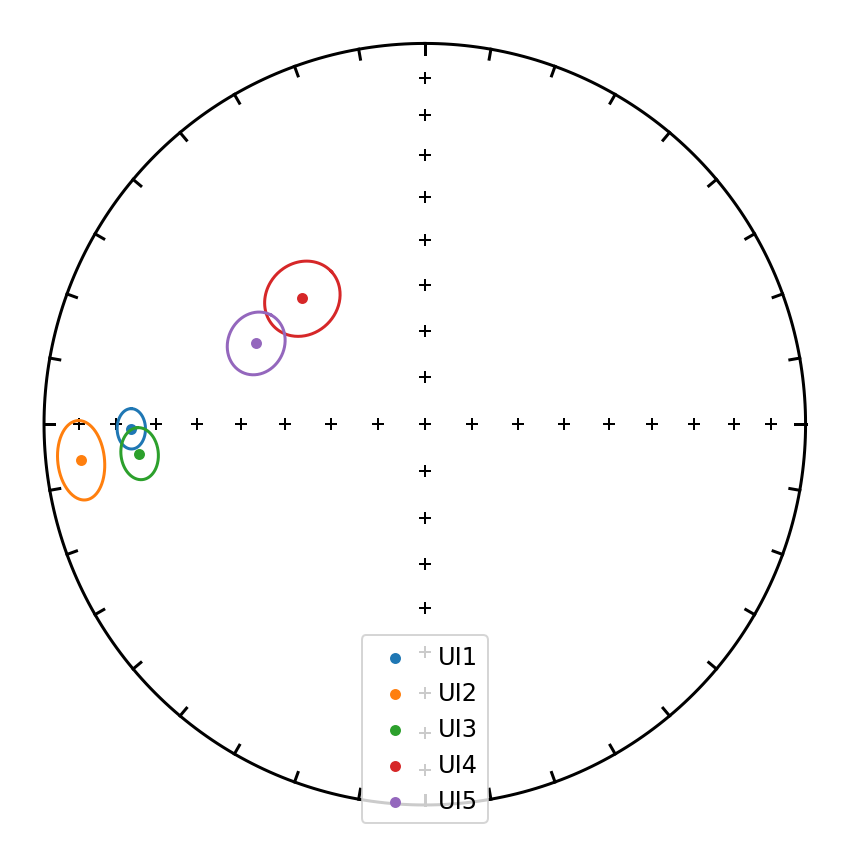

In [5]:
plt.figure(figsize=(6,6))
ipmag.plot_net()
for i in range(UI_site_data_tc.shape[0]):
    ipmag.plot_di_mean(UI_site_data_tc['dir_dec'].tolist()[i], 
                     UI_site_data_tc['dir_inc'].tolist()[i], 
                     UI_site_data_tc['dir_alpha95'].tolist()[i],
                     color = 'C'+str(i), label = UI_site_data_tc['site'].tolist()[i])
plt.legend(loc=8, fontsize=12)
plt.show()

### Unkar mean poles

<Figure size 432x432 with 0 Axes>

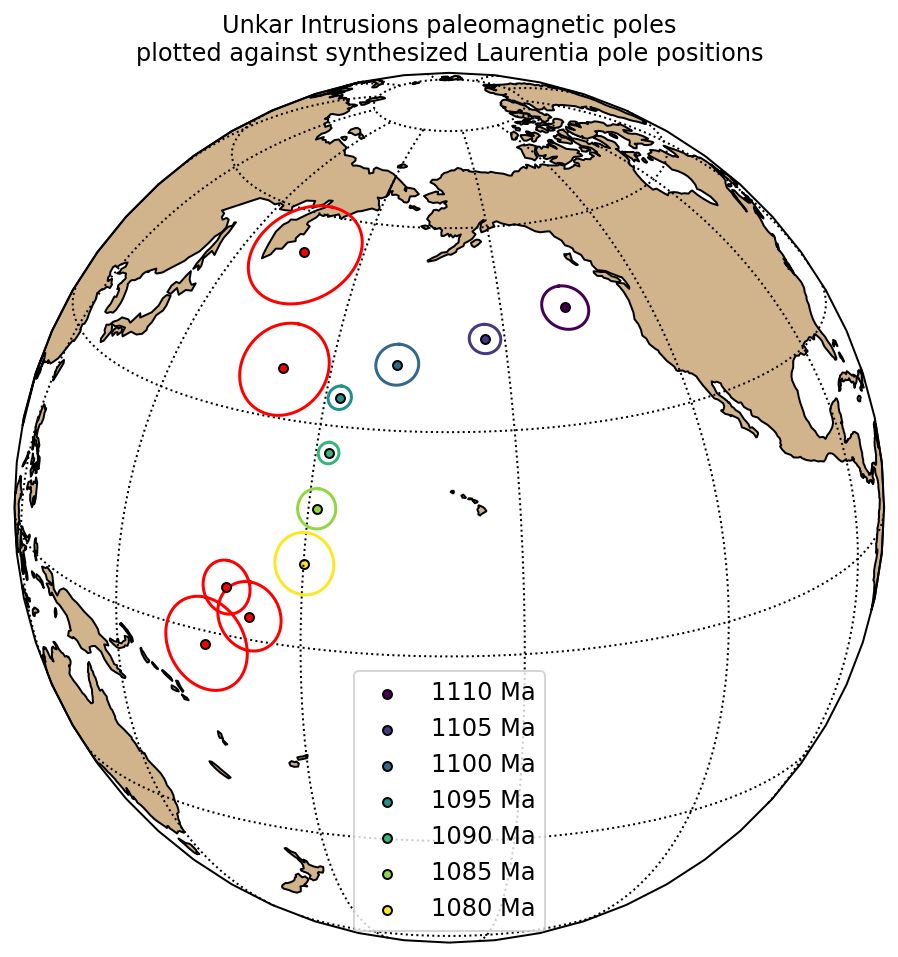

In [46]:
m = plot_APWP()
   
ipmag.plot_poles(m, UI_site_data_tc['vgp_lon'].tolist(), 
                     UI_site_data_tc['vgp_lat'].tolist(), 
                     UI_site_data_tc['dir_alpha95'].tolist(),
                     color = 'r')
plt.title('Unkar Intrusions paleomagnetic poles\nplotted against synthesized Laurentia pole positions')
plt.legend(loc=8, fontsize=12)
# plt.savefig('code_output/Unkar_Poles.pdf', bbox_inches='tight', dpi=500)
plt.show()

### Unkar mean poles with Colorado Rotation

<Figure size 432x432 with 0 Axes>

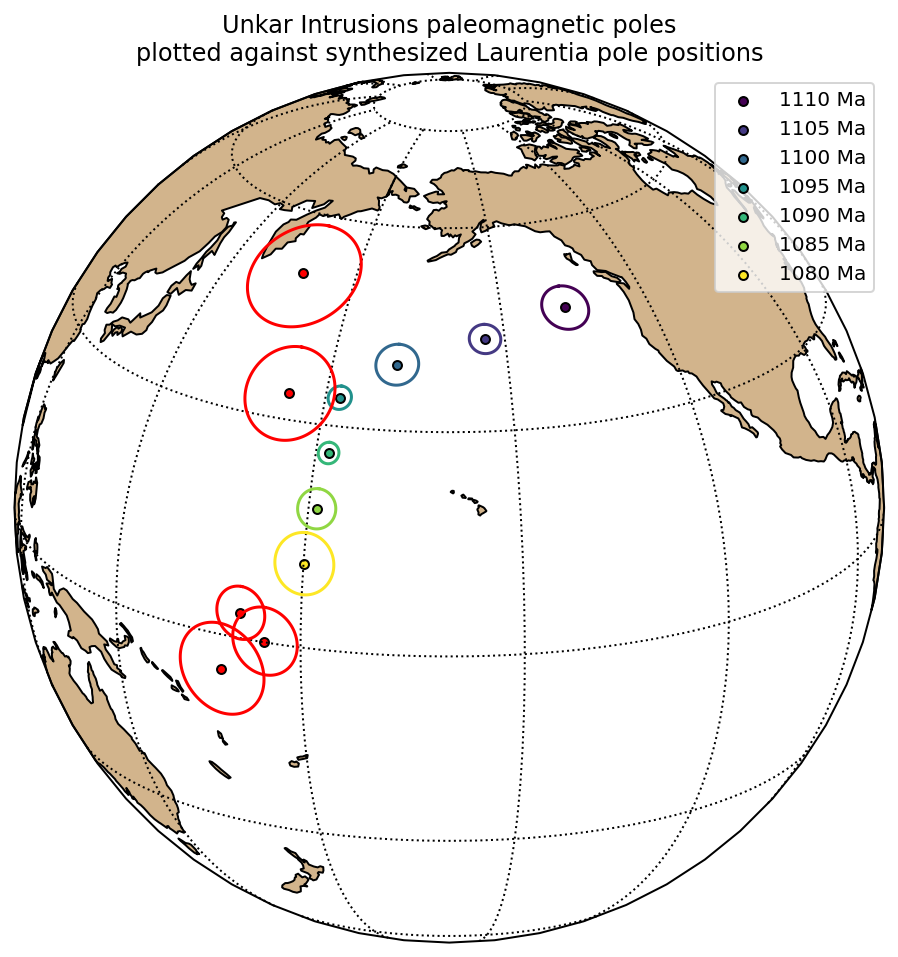

In [7]:
m = plot_APWP()

for i in range(UI_site_data_tc.shape[0]):
    this_lat, this_lon = pmag.pt_rot([37, -103, 3.9], [UI_site_data_tc['vgp_lat'].tolist()[i]], [UI_site_data_tc['vgp_lon'].tolist()[i]])
    
    ipmag.plot_pole(m, this_lon[0], 
                     this_lat[0], 
                     UI_site_data_tc['dir_alpha95'].tolist()[i],
                     color = 'r')
plt.title('Unkar Intrusions paleomagnetic poles\nplotted against synthesized Laurentia pole positions')
plt.legend()
# plt.savefig('code_output/Unkar_Poles.pdf', bbox_inches='tight', dpi=500)
plt.show()

### Cardenas Basalts data

In [8]:
CB_site_data = all_sites_data[all_sites_data['site'].str.contains('CB')].reset_index(drop=1)
# get low temp component in geographic coordinates
CB_site_data_lt_gc = CB_site_data[(CB_site_data['dir_tilt_correction'] == 0) & (CB_site_data['dir_comp_name'] == 'lt')]

# get mid temp component in tilt-corrected coordinates
CB_site_data_mt_tc = CB_site_data[(CB_site_data['dir_tilt_correction'] == 100) & (CB_site_data['dir_comp_name'] == 'mt')]

# get maghemite temp component in tilt-corrected coordinates
CB_site_data_mht_tc = CB_site_data[(CB_site_data['dir_tilt_correction'] == 100) & (CB_site_data['dir_comp_name'] == 'mht')]

# get high temp component in tilt-corrected coordinates
CB_site_data_ht_tc = CB_site_data[(CB_site_data['dir_tilt_correction'] == 100) & (CB_site_data['dir_comp_name'] == 'ht')]

CB_specimen_data = all_specimens_data[all_specimens_data['site'].str.contains('CB')].reset_index(drop=1)
CB_specimen_data_mt_tc = CB_specimen_data[(CB_specimen_data['dir_tilt_correction'] == 100) & (CB_specimen_data['dir_comp'] == 'mt')]
CB_specimen_data_mht_tc = CB_specimen_data[(CB_specimen_data['dir_tilt_correction'] == 100) & (CB_specimen_data['dir_comp'] == 'mht')]
CB_specimen_data_ht_tc = CB_specimen_data[(CB_specimen_data['dir_tilt_correction'] == 100) & (CB_specimen_data['dir_comp'] == 'ht')]

#### Cardenas Basalts low temperature present day local field directions

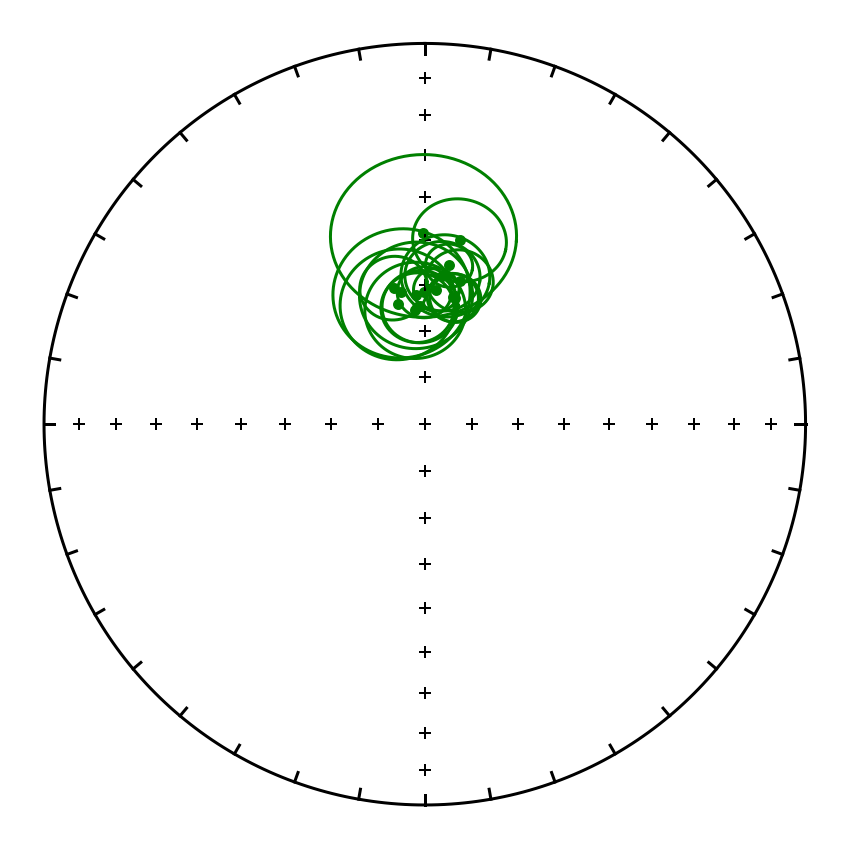

In [9]:
plt.figure(figsize=(6,6))
ipmag.plot_net()
for i in range(CB_site_data_lt_gc.shape[0]):
    ipmag.plot_di_mean(CB_site_data_lt_gc['dir_dec'].tolist()[i], 
                     CB_site_data_lt_gc['dir_inc'].tolist()[i], 
                     CB_site_data_lt_gc['dir_alpha95'].tolist()[i],
                     color = 'green')
# plt.legend()
plt.show()

#### Cardenas Basalts medium temperature magnetite directions

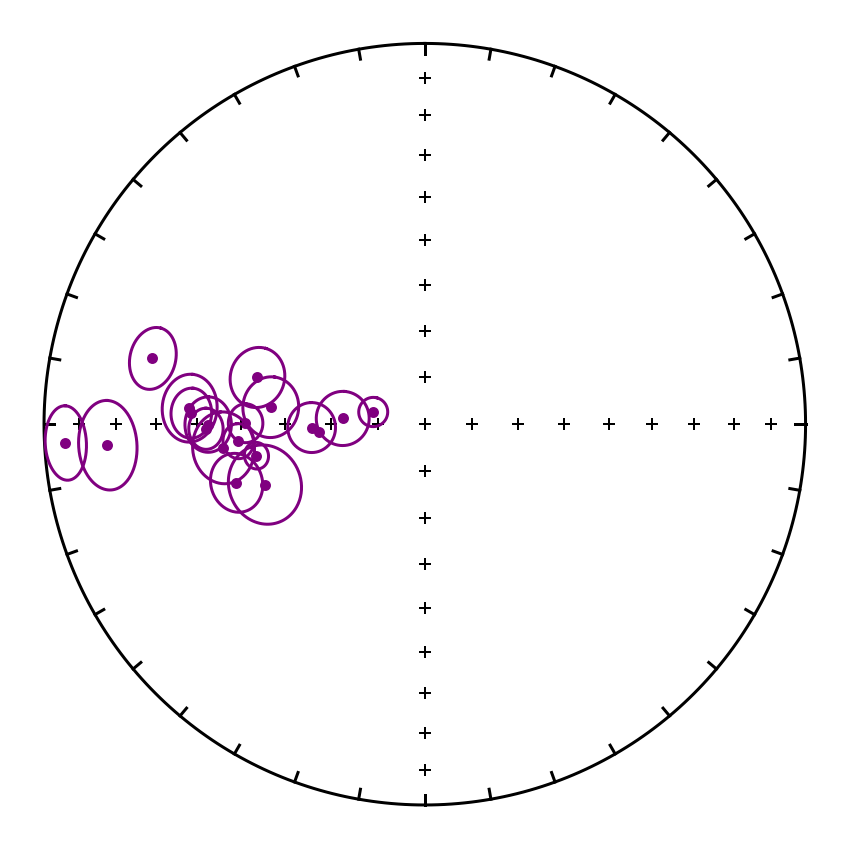

In [10]:
plt.figure(figsize=(6,6))
ipmag.plot_net()
for i in range(CB_site_data_mt_tc.shape[0]):
    ipmag.plot_di_mean(CB_site_data_mt_tc['dir_dec'].tolist()[i], 
                     CB_site_data_mt_tc['dir_inc'].tolist()[i], 
                     CB_site_data_mt_tc['dir_alpha95'].tolist()[i],
                     color = 'purple')
# plt.legend()
plt.show()

### Cardenas Basalts at Nankoweap trail

site CB1, CB2, CB3, CB4, CB5, CB6, CB7 are collected form river mile 52 Nankoweap Trail. 


2 specimens from CB4 has decent mt component; other specimens typically have a mht component that has the opposite direction as the ht component which gets up to 680 degre unblocking temperature. This is likely a signal of having self-reversal magnetization as maghematization alters primary magnetite into maghemite. 

#### CB1

This flow has a lt pdf component and indistinguishable mt and ht directions, consistent with the interpretation that the rocks experienced some oxidation close to the time of eruption and cooling when titanomagnetite acquired remanence.

In [11]:
CB1_site_data_lt_gc = CB_site_data_lt_gc[CB_site_data_lt_gc['site'] == 'CB1']
CB1_site_data_mt_tc = CB_site_data_mt_tc[CB_site_data_mt_tc['site'] == 'CB1']
CB1_site_data_ht_tc = CB_site_data_ht_tc[CB_site_data_ht_tc['site'] == 'CB1']

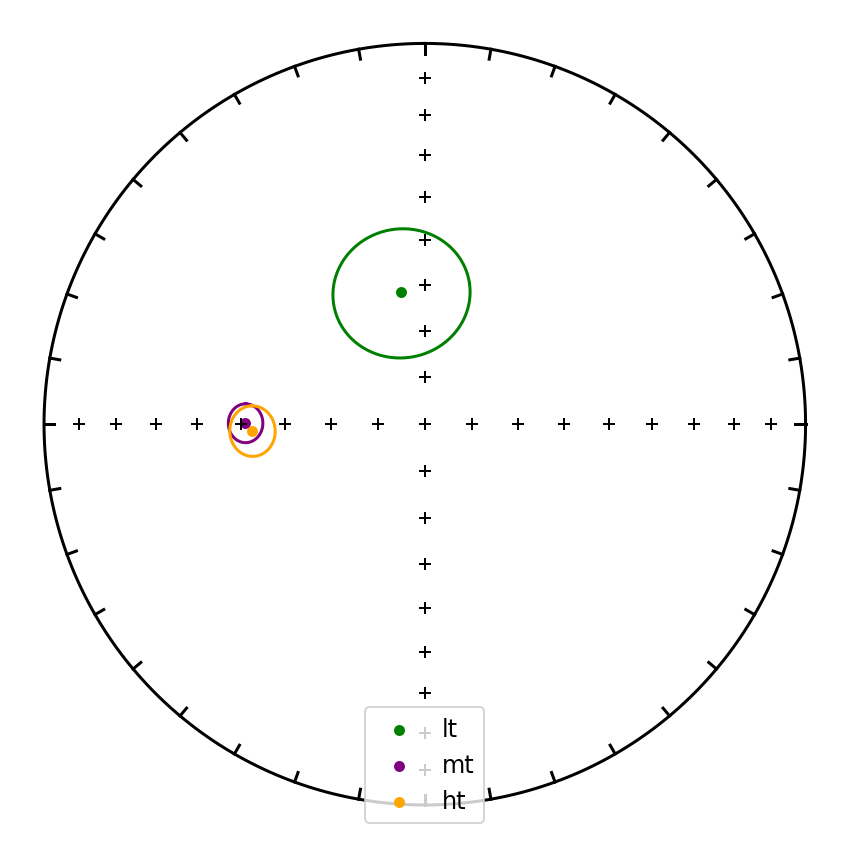

In [12]:
plt.figure(figsize=(6,6))
ipmag.plot_net()
ipmag.plot_di_mean(CB1_site_data_lt_gc.dir_dec.tolist()[0], 
                   CB1_site_data_lt_gc.dir_inc.tolist()[0], 
                   CB1_site_data_lt_gc.dir_alpha95.tolist()[0], 
                   color='green', label='lt')
ipmag.plot_di_mean(CB1_site_data_mt_tc.dir_dec.tolist()[0], 
                   CB1_site_data_mt_tc.dir_inc.tolist()[0], 
                   CB1_site_data_mt_tc.dir_alpha95.tolist()[0], 
                   color='purple', label='mt')
ipmag.plot_di_mean(CB1_site_data_ht_tc.dir_dec.tolist()[0], 
                   CB1_site_data_ht_tc.dir_inc.tolist()[0], 
                   CB1_site_data_ht_tc.dir_alpha95.tolist()[0], 
                   color='orange', label='ht')

plt.legend(loc=8, fontsize=12)
plt.show()

#### CB2

This flow has minimal pdf field direction and a quite steep magnetite mt component

**one note regarding this site is that this is interpreted to be from the same flow as CB3 based on field observations (both are from a 56.8m flow but yet CB2 directions are so steep and distinct from that of CB3. Note that this was Mike's first site, there might be some significant systematic error on block sample collection. But there could be PSV associated with this 50m thick flow.**

In [13]:
CB2_site_data_mt_tc = CB_site_data_mt_tc[CB_site_data_mt_tc['site'] == 'CB2']

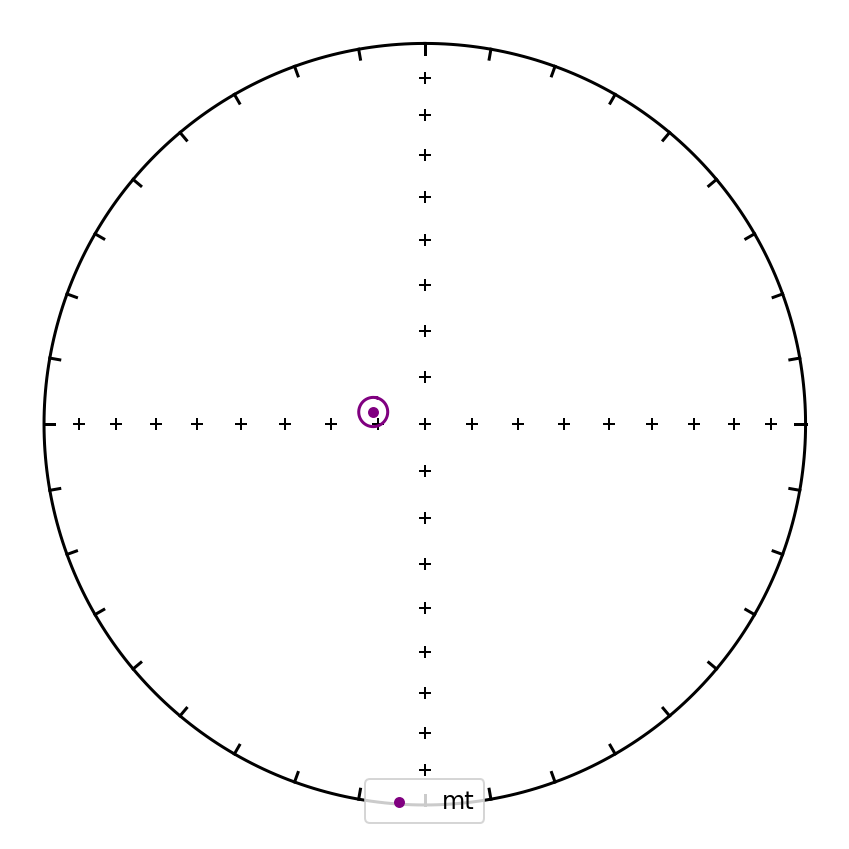

In [14]:
plt.figure(figsize=(6,6))
ipmag.plot_net()
ipmag.plot_di_mean(CB2_site_data_mt_tc.dir_dec.tolist()[0], 
                   CB2_site_data_mt_tc.dir_inc.tolist()[0], 
                   CB2_site_data_mt_tc.dir_alpha95.tolist()[0], 
                   color='purple', label='mt')

plt.legend(loc=8, fontsize=12)
plt.show()

#### CB3

This flow has a pdf field direction and a magnetite mt component and an ht component that overlaps with mt

In [15]:
CB3_site_data_lt_gc = CB_site_data_lt_gc[CB_site_data_lt_gc['site'] == 'CB3']
CB3_site_data_mt_tc = CB_site_data_mt_tc[CB_site_data_mt_tc['site'] == 'CB3']
CB3_site_data_ht_tc = CB_site_data_ht_tc[CB_site_data_ht_tc['site'] == 'CB3']

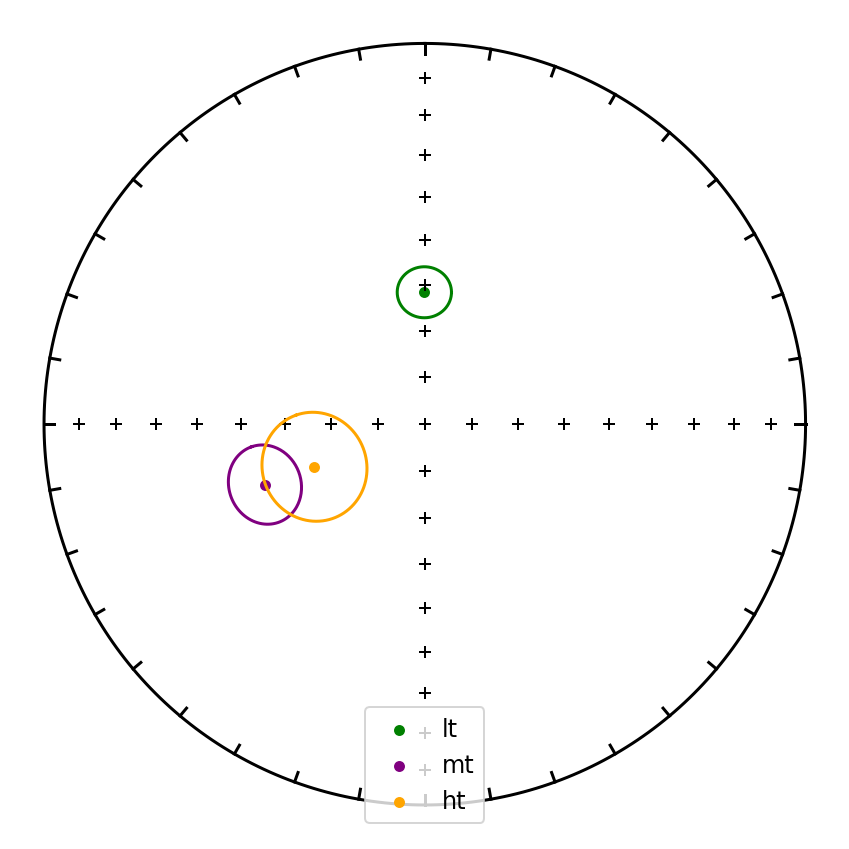

In [16]:
plt.figure(figsize=(6,6))
ipmag.plot_net()
ipmag.plot_di_mean(CB3_site_data_lt_gc.dir_dec.tolist()[0], 
                   CB3_site_data_lt_gc.dir_inc.tolist()[0], 
                   CB3_site_data_lt_gc.dir_alpha95.tolist()[0], 
                   color='green', label='lt')
ipmag.plot_di_mean(CB3_site_data_mt_tc.dir_dec.tolist()[0], 
                   CB3_site_data_mt_tc.dir_inc.tolist()[0], 
                   CB3_site_data_mt_tc.dir_alpha95.tolist()[0], 
                   color='purple', label='mt')
ipmag.plot_di_mean(CB3_site_data_ht_tc.dir_dec.tolist()[0], 
                   CB3_site_data_ht_tc.dir_inc.tolist()[0], 
                   CB3_site_data_ht_tc.dir_alpha95.tolist()[0], 
                   color='orange', label='ht')

plt.legend(loc=8, fontsize=12)
plt.show()

#### CB4

This flow is a special one. It is in general fine-grained, vesicular basalt that appears red in color. It has a complex combination of four components including a lt pdf component, a mt magnetite direction in a couple of samples that record the expected direction at ca. 1083 Ma, and a dominant mht component that always has an antipodal direction as the mt and ht, and a high temperature ht component that record directions similar to mt component.

Specimen 2a is collected 20 cm above the base of the flow. This specimen is the only one that does not have an antipode direction. Its mt component unblock up to ca. 580 C when it was almost completely demagnetized. 

In all other specimens, the mht component typically unblocks between 350-600 C and have antipodal directions to their ht component directions.

**CB4 specimen mht and ht directions pass common mean test with classification of 'C'**

**CB4 specimen mht and ht+mt directions pass common mean test with classification of 'C'**

**we combine the mt direction from specimen 2a and the ht directions from other specimens to calculate a mean for this site**

In [22]:
CB4_site_data_lt_gc = CB_site_data_lt_gc[CB_site_data_lt_gc['site'] == 'CB4']
CB4_site_data_mht_tc = CB_site_data_mht_tc
CB4_site_ht_tc = CB_site_data_ht_tc[CB_site_data_ht_tc['site'] == 'CB4']

CB4_specimen_ht_tc = CB_specimen_data_ht_tc[CB_specimen_data_ht_tc['site'] == 'CB4']
CB4_specimen_mht_tc = CB_specimen_data_mht_tc[CB_specimen_data_mht_tc['site'] == 'CB4']
CB4_specimen_mt_tc = CB_specimen_data_mt_tc[CB_specimen_data_mt_tc['site'] == 'CB4']

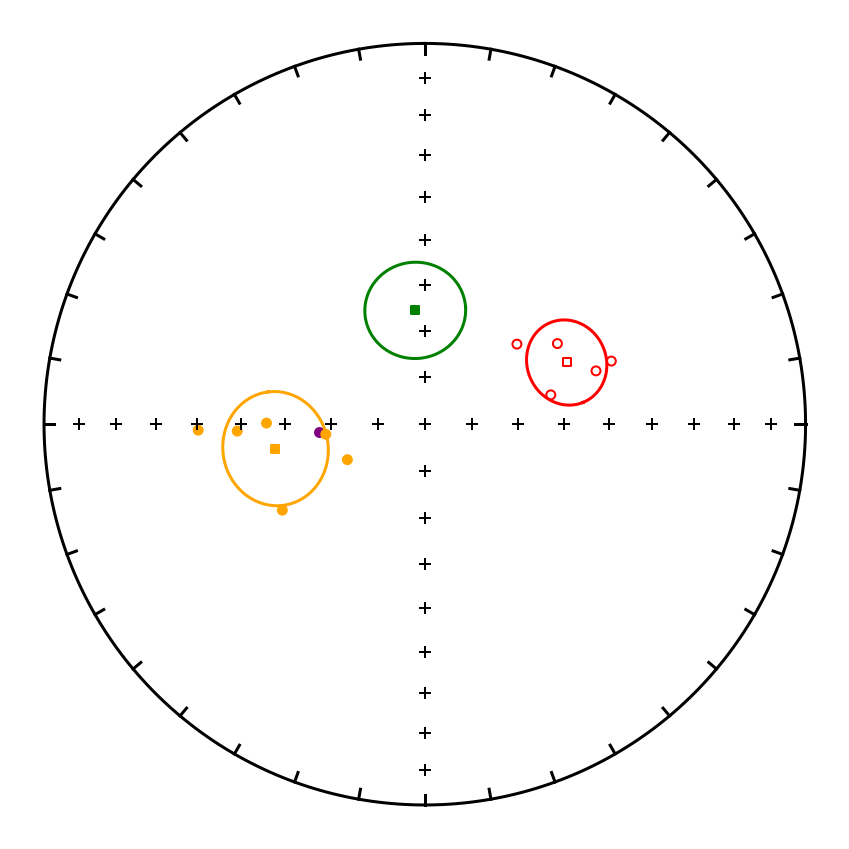

In [19]:
plt.figure(figsize=(6,6))
ipmag.plot_net()

ipmag.plot_di(CB4_specimen_mt_tc['dir_dec'].tolist(), 
              CB4_specimen_mt_tc['dir_inc'].tolist(), 
              color = 'purple')
ipmag.plot_di(CB4_specimen_mht_tc['dir_dec'].tolist(), 
              CB4_specimen_mht_tc['dir_inc'].tolist(), 
              color = 'red')
ipmag.plot_di(CB4_specimen_ht_tc['dir_dec'].tolist(), 
              CB4_specimen_ht_tc['dir_inc'].tolist(), 
              color = 'orange')


ipmag.plot_di_mean(CB4_site_data_lt_gc.dir_dec.tolist()[0], 
                   CB4_site_data_lt_gc.dir_inc.tolist()[0], 
                   CB4_site_data_lt_gc.dir_alpha95.tolist()[0], 
                   marker = 's', color='green', label='lt')

ipmag.plot_di_mean(CB4_site_data_mht_tc['dir_dec'].tolist()[0],  
                   CB4_site_data_mht_tc['dir_inc'].tolist()[0], 
                   CB4_site_data_mht_tc['dir_alpha95'].tolist()[0], 
                   marker = 's', color='red', label='mht')

ipmag.plot_di_mean(CB4_site_ht_tc['dir_dec'].tolist()[0],  
                   CB4_site_ht_tc['dir_inc'].tolist()[0], 
                   CB4_site_ht_tc['dir_alpha95'].tolist()[0], 
                   marker = 's', color='orange')

In [20]:
ipmag.reversal_test_MM1990(dec=CB4_specimen_ht_tc['dir_dec'].tolist()+CB4_specimen_mht_tc['dir_dec'].tolist(), 
                           inc=CB4_specimen_ht_tc['dir_inc'].tolist()+CB4_specimen_mht_tc['dir_inc'].tolist())

Results of Watson V test: 

Watson's V:           2.4
Critical value of V:  7.2
"Pass": Since V is less than Vcrit, the null hypothesis
that the two populations are drawn from distributions
that share a common mean direction can not be rejected.

M&M1990 classification:

Angle between data set means: 7.8
Critical angle for M&M1990:   13.5
The McFadden and McElhinny (1990) classification for
this test is: 'C'


(1, 7.780376177760243, 13.462578316921848, 'C')

In [21]:
ipmag.reversal_test_MM1990(dec=CB4_specimen_ht_tc['dir_dec'].tolist()+CB4_specimen_mht_tc['dir_dec'].tolist()+CB4_specimen_mt_tc['dir_dec'].tolist(), 
                           inc=CB4_specimen_ht_tc['dir_inc'].tolist()+CB4_specimen_mht_tc['dir_inc'].tolist()+CB4_specimen_mt_tc['dir_inc'].tolist())

Results of Watson V test: 

Watson's V:           3.1
Critical value of V:  7.0
"Pass": Since V is less than Vcrit, the null hypothesis
that the two populations are drawn from distributions
that share a common mean direction can not be rejected.

M&M1990 classification:

Angle between data set means: 8.2
Critical angle for M&M1990:   12.4
The McFadden and McElhinny (1990) classification for
this test is: 'C'


(1, 8.167620593619487, 12.357897096848367, 'C')

In [23]:
CB4_directions = pd.concat([CB4_specimen_ht_tc, CB4_specimen_mt_tc])
CB4_directions.head()

,specimen,experiments,sample,dir_alpha95,dir_comp,dir_dec,dir_inc,dir_n_comps,dir_n_measurements,dir_tilt_correction,...,instrument_codes,software_packages,int_corr,citations,method_codes,result_quality,volume,weight,location,site
649,CB4-3a,CB4-3a_LP-DIR-T,CB4-3,NaN,ht,238.9,54.0,3.0,8.0,100.0,...,hargrave 2021-12-03 19:34:42,pmagpy-4.2.24-1: demag_gui,u,This study,LP-DIR-T:DE-BFL:DA-DIR-TILT,g,NaN,NaN,Grand Canyon,CB4
657,CB4-4a,CB4-4a_LP-DIR-T,CB4-4,NaN,ht,264.2,68.7,3.0,25.0,100.0,...,hargrave 2021-12-03 19:36:26,pmagpy-4.2.24-1: demag_gui,u,This study,LP-DIR-T:DE-BFL-A:DA-DIR-TILT,g,NaN,NaN,Grand Canyon,CB4
675,CB4-5a,CB4-5a_LP-DIR-T,CB4-5,NaN,ht,267.9,49.2,3.0,11.0,100.0,...,hargrave 2021-12-03 19:39:11,pmagpy-4.2.24-1: demag_gui,u,This study,LP-DIR-T:DE-BFL-A:DA-DIR-TILT,g,NaN,NaN,Grand Canyon,CB4
684,CB4-6a,CB4-6a_LP-DIR-T,CB4-6,NaN,ht,270.4,55.8,3.0,9.0,100.0,...,hargrave 2021-12-03 19:40:39,pmagpy-4.2.24-1: demag_gui,u,This study,LP-DIR-T:DE-BFL:DA-DIR-TILT,g,NaN,NaN,Grand Canyon,CB4
686,CB4-7a,CB4-7a_LP-DIR-T,CB4-7,NaN,ht,268.5,40.2,3.0,12.0,100.0,...,hargrave 2021-12-03 19:42:04,pmagpy-4.2.24-1: demag_gui,u,This study,LP-DIR-T:DE-BFL:DA-DIR-TILT,g,NaN,NaN,Grand Canyon,CB4


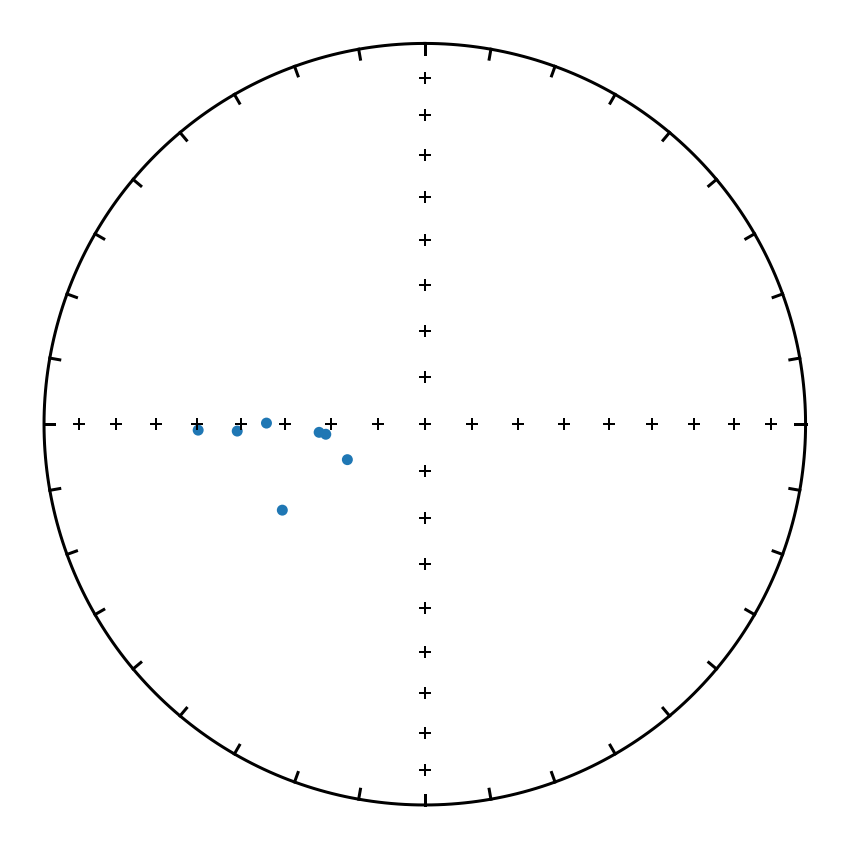

In [25]:
plt.figure(figsize=(6,6))
ipmag.plot_net()
ipmag.plot_di(CB4_directions['dir_dec'].tolist(), 
                     CB4_directions['dir_inc'].tolist(),
                     color = 'C0')
plt.show()

**recalculate CB4 mean direction using combined mt, mht, ht components**

In [26]:
CB4_mean_dir = ipmag.fisher_mean(CB4_directions['dir_dec'].tolist(), CB4_directions['dir_inc'].tolist())
CB4_mean_dir

{'dec': 261.25948616158814,
 'inc': 58.693912646228306,
 'n': 7,
 'r': 6.838397544216533,
 'k': 37.12814864669793,
 'alpha95': 10.036357588532361,
 'csd': 13.293317321091129}

**recalculate CB4 mean pole using combined mt, mht, ht components**

In [33]:
CB4_vgps = np.array([pmag.dia_vgp(CB4_directions['dir_dec'].tolist()[i], 
                                  CB4_directions['dir_inc'].tolist()[i], 
                                  0, 
                                  CB4_site_data_mht_tc['lat'].tolist()[0], 
                                  CB4_site_data_mht_tc['lon'].tolist()[0]) for i in range(CB4_directions.shape[0])]).T[:2]
CB4_dpdm = pmag.dia_vgp(CB4_mean_dir['dec'], 
                        CB4_mean_dir['inc'], 
                        CB4_mean_dir['alpha95'], 
                        CB4_site_data_mht_tc['lat'].tolist()[0], 
                        CB4_site_data_mht_tc['lon'].tolist()[0])
CB4_mean_pole = ipmag.fisher_mean(CB4_vgps[0], CB4_vgps[1])

#### CB5

This flow has a lt pdf component and indistinguishable mt and ht directions, consistent with the interpretation that the rocks experienced some oxidation close to the time of eruption and cooling when titanomagnetite acquired remanence.

In [37]:
CB5_site_data_lt_gc = CB_site_data_lt_gc[CB_site_data_lt_gc['site'] == 'CB5']
CB5_site_data_mt_tc = CB_site_data_mt_tc[CB_site_data_mt_tc['site'] == 'CB5']
CB5_site_data_ht_tc = CB_site_data_ht_tc[CB_site_data_ht_tc['site'] == 'CB5']

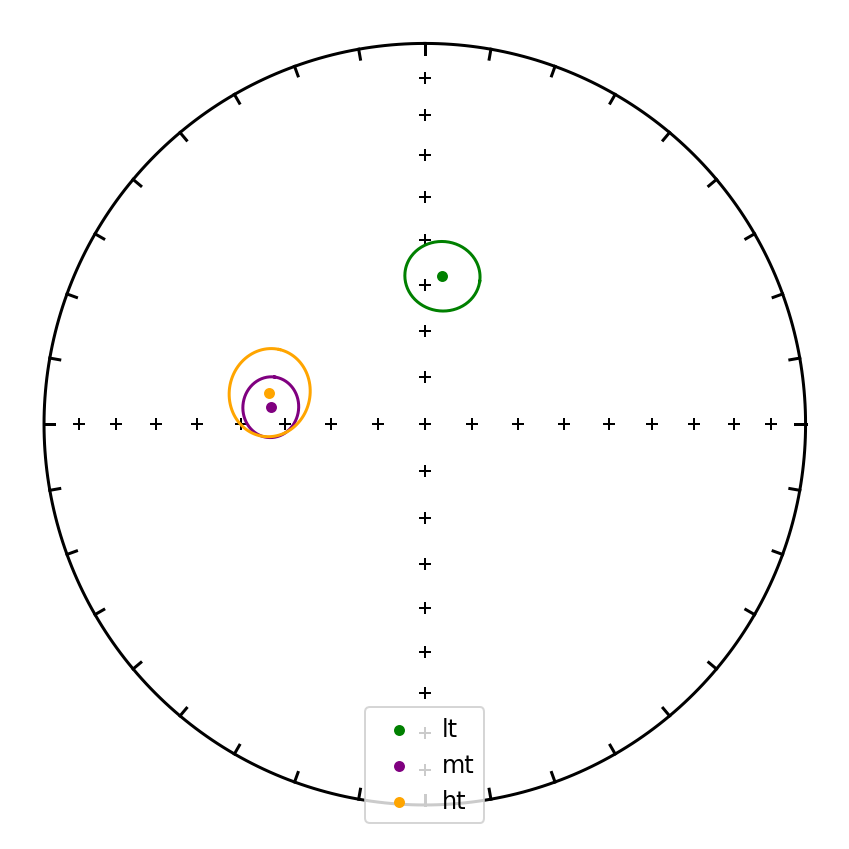

In [38]:
plt.figure(figsize=(6,6))
ipmag.plot_net()
ipmag.plot_di_mean(CB5_site_data_lt_gc.dir_dec.tolist()[0], 
                   CB5_site_data_lt_gc.dir_inc.tolist()[0], 
                   CB5_site_data_lt_gc.dir_alpha95.tolist()[0], 
                   color='green', label='lt')
ipmag.plot_di_mean(CB5_site_data_mt_tc.dir_dec.tolist()[0], 
                   CB5_site_data_mt_tc.dir_inc.tolist()[0], 
                   CB5_site_data_mt_tc.dir_alpha95.tolist()[0], 
                   color='purple', label='mt')
ipmag.plot_di_mean(CB5_site_data_ht_tc.dir_dec.tolist()[0], 
                   CB5_site_data_ht_tc.dir_inc.tolist()[0], 
                   CB5_site_data_ht_tc.dir_alpha95.tolist()[0], 
                   color='orange', label='ht')

plt.legend(loc=8, fontsize=12)
plt.show()

#### Nankoweap summary

combining CB1-CB5 site data with updated CB4 directions (combining ht and mt directions)

In [34]:
CB_Nankoweap_tc = CB_site_data_mt_tc[CB_site_data_mt_tc['site'].isin(['CB1','CB2','CB3','CB5'])]

In [35]:
CB_Nankoweap_tc=CB_Nankoweap_mt_tc.append({ 'site': 'CB4',
                            'location':                                                       'Grand Canyon',
                            'samples':                    ' CB4-1:CB4-2:CB4-3:CB4-4:CB4-5:CB4-6:CB4-7:CB4-8',
                            'specimens':           'CB4-1a:CB4-2a:CB4-3a:CB4-4a:CB4-5a:CB4-6a:CB4-7a:CB4-8a',
                            'dir_alpha95':                                   round(CB4_mean_dir['alpha95'],1),
                            'dir_comp_name':                                                            'mt',
                            'dir_dec':                                                              round(CB4_mean_dir['dec'],1),
                            'dir_inc':                                                              round(CB4_mean_dir['inc'],1),
                            'dir_k':                                                                round(CB4_mean_dir['k'],1),
                            'dir_n_samples':                                                        8,
                            'dir_n_specimens':                                                      8,
                            'dir_n_specimens_lines':                                                8,
                            'dir_n_specimens_planes':                                               0,
                            'dir_polarity':                                                              't',
                            'dir_r':                                                                round(CB4_mean_dir['r'],1),
                            'dir_tilt_correction':                                                     100,
                            'lat':                                                                   CB4_site_data_mht_tc['lat'].tolist()[0],
                            'lon':                                                                  CB4_site_data_mht_tc['lon'].tolist()[0],
                            'analysts':                                                                'NaN',
                            'criteria':                                                             'ACCEPT',
                            'software_packages':                          'pmagpy-4.2.24-1: demag_gui.v.3.0',
                            'citations':                                                        'This study',
                            'method_codes':              'LP-DIR-T:DE-BFL:DA-DIR-TILT:LP-DC4:DE-FM:DA-DIR-GEO',
                            'result_quality':                                                            'g',
                            'vgp_dm':                                                                  CB4_dpdm[2],
                            'vgp_dp':                                                                  CB4_dpdm[3],
                            'vgp_lat':                                                                CB4_mean_pole['inc'],
                            'vgp_lon':                                                               CB4_mean_pole['dec']}, ignore_index=1)


In [36]:
CB_Nankoweap_mt_tc

,site,location,samples,specimens,dir_alpha95,dir_comp_name,dir_dec,dir_inc,dir_k,dir_n_samples,...,analysts,criteria,software_packages,citations,method_codes,result_quality,vgp_dm,vgp_dp,vgp_lat,vgp_lon
0,CB1,Grand Canyon,CB1-1:CB1-2:CB1-3:CB1-4:CB1-5:CB1-6:CB1-7:CB1-8,CB1-1a:CB1-2a:CB1-3a:CB1-4a:CB1-5a:CB1-6a:CB1-...,3.9,mt,270.3,51.1,200.0,8,...,NaN,ACCEPT,pmagpy-4.2.24-1: demag_gui.v.3.0,This study,LP-DIR-T:DE-BFL-A:DA-DIR-TILT:LP-DC4:DE-FM:DA-...,g,5.30,3.60,18.300000,184.700000
1,CB2,Grand Canyon,CB2-1:CB2-2:CB2-3:CB2-4:CB2-5:CB2-6:CB2-7:CB2-8,CB2-1a:CB2-2a:CB2-3a:CB2-4a:CB2-5a:CB2-6a:CB2-...,3.1,mt,283.3,78.7,329.0,8,...,NaN,ACCEPT,pmagpy-4.2.24-1: demag_gui.v.3.0,This study,LP-DIR-T:DE-BFL-A:DA-DIR-TILT:LP-DC4:DE-FM:DA-...,g,5.90,5.60,38.000000,220.900000
2,CB3,Grand Canyon,CB3-1:CB3-2:CB3-3:CB3-4:CB3-6:CB3-7:CB3-8,CB3-1a:CB3-2a:CB3-3a:CB3-4a:CB3-6a:CB3-7a:CB3-8a,8.1,mt,249.3,52.9,56.0,7,...,NaN,ACCEPT,pmagpy-4.2.24-1: demag_gui.v.3.0,This study,LP-DIR-T:DE-BFL-A:DA-DIR-TILT:LP-DC4:DE-FM:DA-...,g,11.20,7.70,5.000000,196.600000
3,CB5,Grand Canyon,CB5-1:CB5-2:CB5-3:CB5-4:CB5-5:CB5-6:CB5-7:CB5-...,CB5-1a:CB5-2a:CB5-3a:CB5-4a:CB5-5a:CB5-6a:CB5-...,6.2,mt,276.3,56.5,71.0,9,...,NaN,ACCEPT,pmagpy-4.2.24-1: demag_gui.v.3.0,This study,LP-DIR-T:DE-BFL-A:DA-DIR-TILT:LP-DC4:DE-FM:DA-...,g,9.00,6.50,25.200000,187.000000
4,CB4,Grand Canyon,CB4-1:CB4-2:CB4-3:CB4-4:CB4-5:CB4-6:CB4-7:CB4-8,CB4-1a:CB4-2a:CB4-3a:CB4-4a:CB4-5a:CB4-6a:CB4-...,10.0,mt,261.3,58.7,37.1,8,...,NaN,ACCEPT,pmagpy-4.2.24-1: demag_gui.v.3.0,This study,LP-DIR-T:DE-BFL:DA-DIR-TILT:LP-DC4:DE-FM:DA-DI...,g,11.09,14.92,16.800649,197.073872


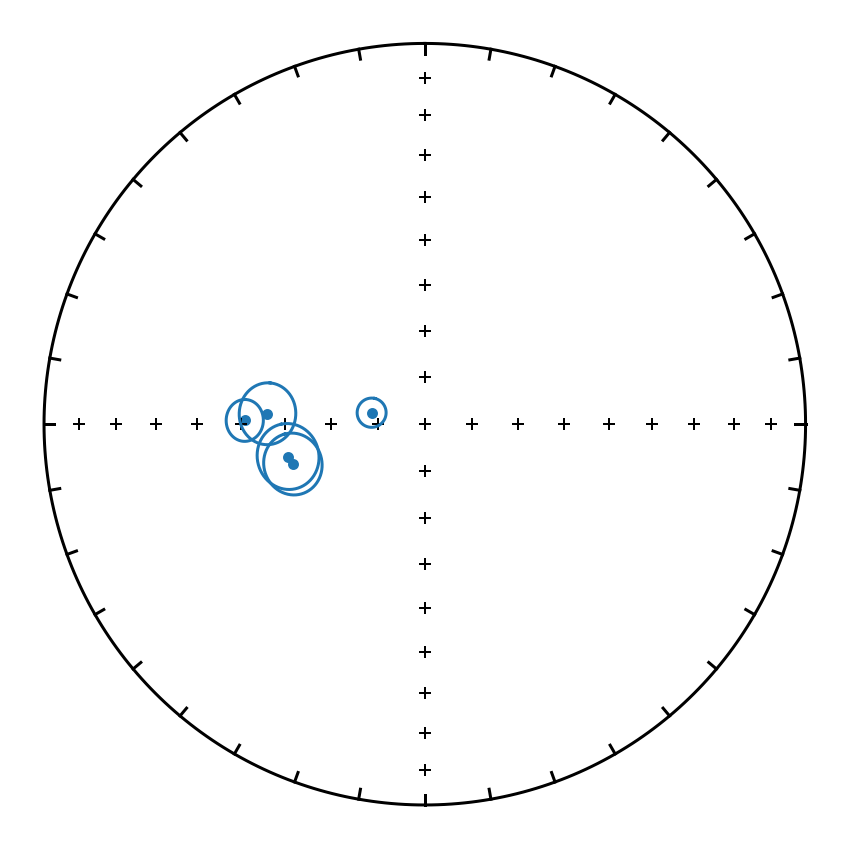

In [22]:
plt.figure(figsize=(6,6))
ipmag.plot_net()
for i in range(CB_Nankoweap_mt_tc.shape[0]):
    ipmag.plot_di_mean(CB_Nankoweap_mt_tc['dir_dec'].tolist()[i], 
                     CB_Nankoweap_mt_tc['dir_inc'].tolist()[i], 
                     CB_Nankoweap_mt_tc['dir_alpha95'].tolist()[i],
                     color = 'purple')

# plt.legend()
plt.show()

<Figure size 432x432 with 0 Axes>

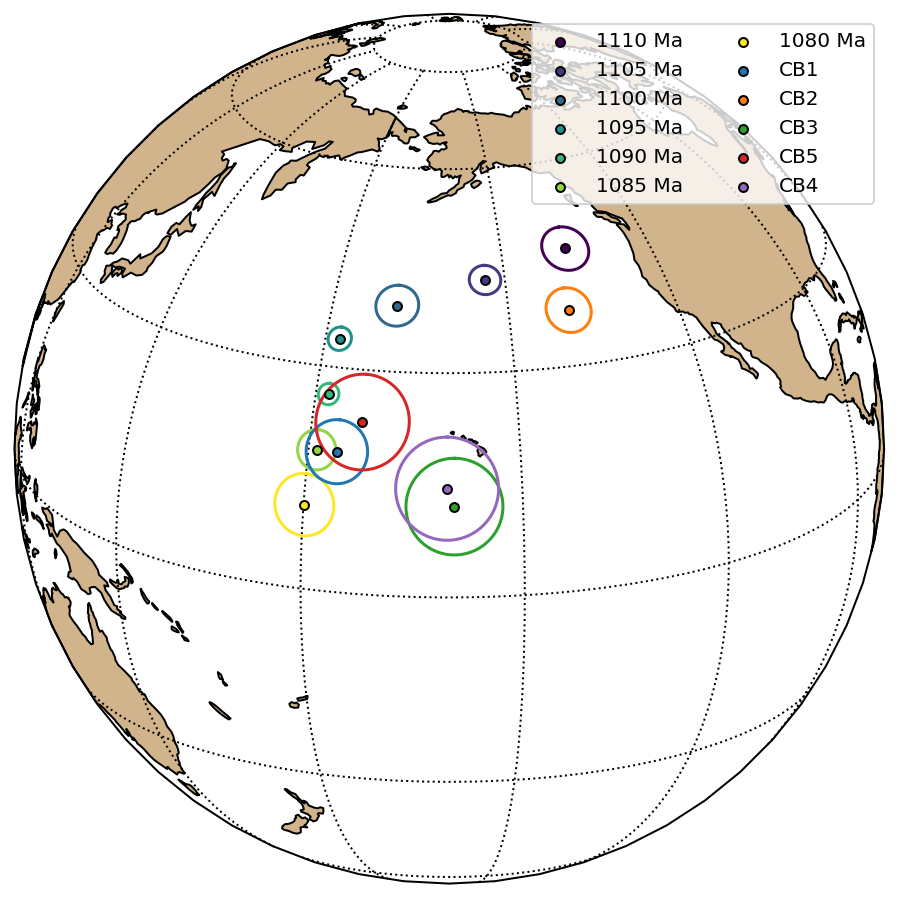

In [23]:
plt.figure(figsize = (6,6))
m = ipmag.make_orthographic_map(central_longitude=200, central_latitude=20)

synthetic_ages = [1080, 1085, 1090, 1095, 1100, 1105, 1110]
cNorm  = colors.Normalize(vmin=min(synthetic_ages), vmax=max(synthetic_ages))
scalarMap = matplotlib.cm.ScalarMappable(norm=cNorm, cmap='viridis')

synthetic_colors = [colors.rgb2hex(scalarMap.to_rgba(synthetic_ages[i])) for i in range(len(synthetic_ages))]

one_Euler_pole_lon = np.loadtxt('../data/mcplates_results/pole_lon_positions_2_true.txt')
one_Euler_pole_lat = np.loadtxt('../data/mcplates_results/pole_lat_positions_2_true.txt')

fisher0 = ipmag.fisher_mean(one_Euler_pole_lon[:,0]+180,one_Euler_pole_lat[:,0])
theta0 = ipmag.fisher_angular_deviation(one_Euler_pole_lon[:,0]+180,one_Euler_pole_lat[:,0])
fisher0['theta'] = theta0
ipmag.plot_pole(m,fisher0['dec'],fisher0['inc'],theta0,color=synthetic_colors[0],label='1110 Ma')

fisher1 = ipmag.fisher_mean(one_Euler_pole_lon[:,1]+180,one_Euler_pole_lat[:,1])
theta1 = ipmag.fisher_angular_deviation(one_Euler_pole_lon[:,1]+180,one_Euler_pole_lat[:,1])
fisher1['theta'] = theta1
ipmag.plot_pole(m,fisher1['dec'],fisher1['inc'],theta1,color=synthetic_colors[1],label='1105 Ma')

fisher2 = ipmag.fisher_mean(one_Euler_pole_lon[:,2]+180,one_Euler_pole_lat[:,2])
theta2 = ipmag.fisher_angular_deviation(one_Euler_pole_lon[:,2]+180,one_Euler_pole_lat[:,2])
fisher2['theta'] = theta2
ipmag.plot_pole(m,fisher2['dec'],fisher2['inc'],theta2,color=synthetic_colors[2],label='1100 Ma')

fisher3 = ipmag.fisher_mean(one_Euler_pole_lon[:,3]+180,one_Euler_pole_lat[:,3])
theta3 = ipmag.fisher_angular_deviation(one_Euler_pole_lon[:,3]+180,one_Euler_pole_lat[:,3])
fisher3['theta'] = theta3
ipmag.plot_pole(m,fisher3['dec'],fisher3['inc'],theta3,color=synthetic_colors[3],label='1095 Ma')

fisher4 = ipmag.fisher_mean(one_Euler_pole_lon[:,4]+180,one_Euler_pole_lat[:,4])
theta4 = ipmag.fisher_angular_deviation(one_Euler_pole_lon[:,4]+180,one_Euler_pole_lat[:,4])
fisher4['theta'] = theta4
ipmag.plot_pole(m,fisher4['dec'],fisher4['inc'],theta4,color=synthetic_colors[4],label='1090 Ma')

fisher5 = ipmag.fisher_mean(one_Euler_pole_lon[:,5]+180,one_Euler_pole_lat[:,5])
theta5 = ipmag.fisher_angular_deviation(one_Euler_pole_lon[:,5]+180,one_Euler_pole_lat[:,5])
fisher5['theta'] = theta5
ipmag.plot_pole(m,fisher5['dec'],fisher5['inc'],theta5,color=synthetic_colors[5],label='1085 Ma')

fisher6 = ipmag.fisher_mean(one_Euler_pole_lon[:,6]+180,one_Euler_pole_lat[:,6])
theta6 = ipmag.fisher_angular_deviation(one_Euler_pole_lon[:,6]+180,one_Euler_pole_lat[:,6])
fisher6['theta'] = theta6
ipmag.plot_pole(m,fisher6['dec'],fisher6['inc'],theta6,color=synthetic_colors[6],label='1080 Ma')

for i in range(CB_Nankoweap_mt_tc.shape[0]):
    ipmag.plot_pole(m, CB_Nankoweap_mt_tc['vgp_lon'].tolist()[i], 
                     CB_Nankoweap_mt_tc['vgp_lat'].tolist()[i], 
                     CB_Nankoweap_mt_tc['dir_alpha95'].tolist()[i],
                     color = 'C'+str(i), label = CB_Nankoweap_mt_tc['site'].tolist()[i])


plt.legend(ncol=2)
plt.show()

### Cardenas Basalts at Lava Chuar Canyon

site CB6, CB7 are collected form river mile 65 Lava Chuar

#### CB6

This flow has a lt pdf component and indistinguishable mt and ht directions, consistent with the interpretation that the rocks experienced some oxidation close to the time of eruption and cooling when titanomagnetite acquired remanence.

In [39]:
CB6_site_data_lt_gc = CB_site_data_lt_gc[CB_site_data_lt_gc['site'] == 'CB6']
CB6_site_data_mt_tc = CB_site_data_mt_tc[CB_site_data_mt_tc['site'] == 'CB6']
CB6_site_data_ht_tc = CB_site_data_ht_tc[CB_site_data_ht_tc['site'] == 'CB6']

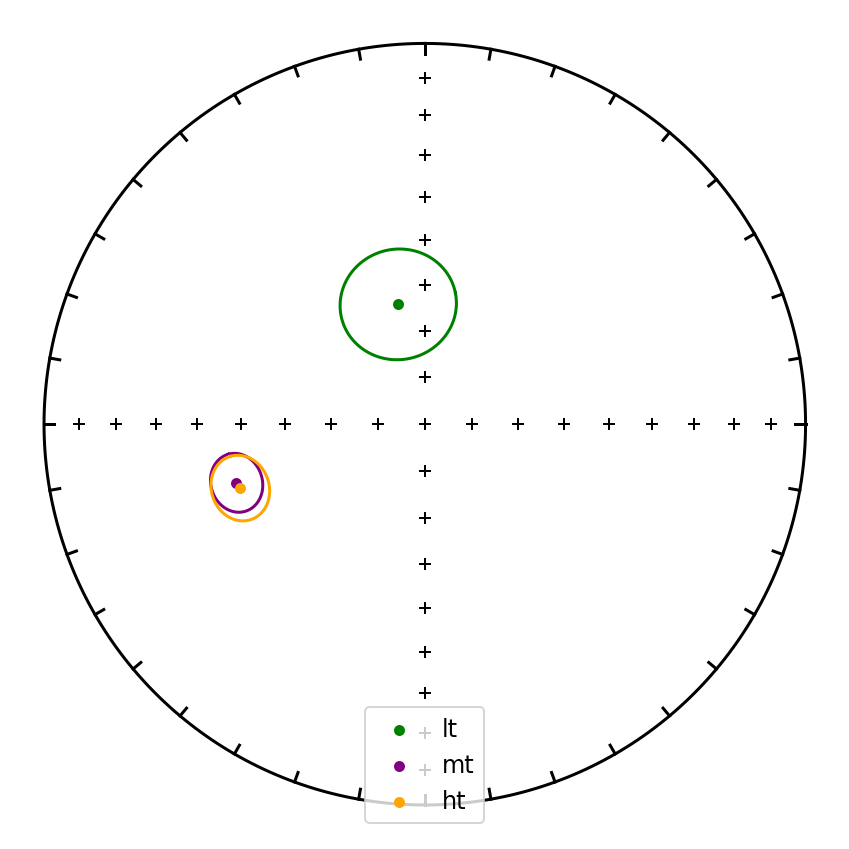

In [40]:
plt.figure(figsize=(6,6))
ipmag.plot_net()
ipmag.plot_di_mean(CB6_site_data_lt_gc.dir_dec.tolist()[0], 
                   CB6_site_data_lt_gc.dir_inc.tolist()[0], 
                   CB6_site_data_lt_gc.dir_alpha95.tolist()[0], 
                   color='green', label='lt')
ipmag.plot_di_mean(CB6_site_data_mt_tc.dir_dec.tolist()[0], 
                   CB6_site_data_mt_tc.dir_inc.tolist()[0], 
                   CB6_site_data_mt_tc.dir_alpha95.tolist()[0], 
                   color='purple', label='mt')
ipmag.plot_di_mean(CB6_site_data_ht_tc.dir_dec.tolist()[0], 
                   CB6_site_data_ht_tc.dir_inc.tolist()[0], 
                   CB6_site_data_ht_tc.dir_alpha95.tolist()[0], 
                   color='orange', label='ht')

plt.legend(loc=8, fontsize=12)
plt.show()

#### CB7

This flow has a lt pdf component and indistinguishable mt and ht directions, consistent with the interpretation that the rocks experienced some oxidation close to the time of eruption and cooling when titanomagnetite acquired remanence.

In [41]:
CB7_site_data_lt_gc = CB_site_data_lt_gc[CB_site_data_lt_gc['site'] == 'CB7']
CB7_site_data_mt_tc = CB_site_data_mt_tc[CB_site_data_mt_tc['site'] == 'CB7']
CB7_site_data_ht_tc = CB_site_data_ht_tc[CB_site_data_ht_tc['site'] == 'CB7']

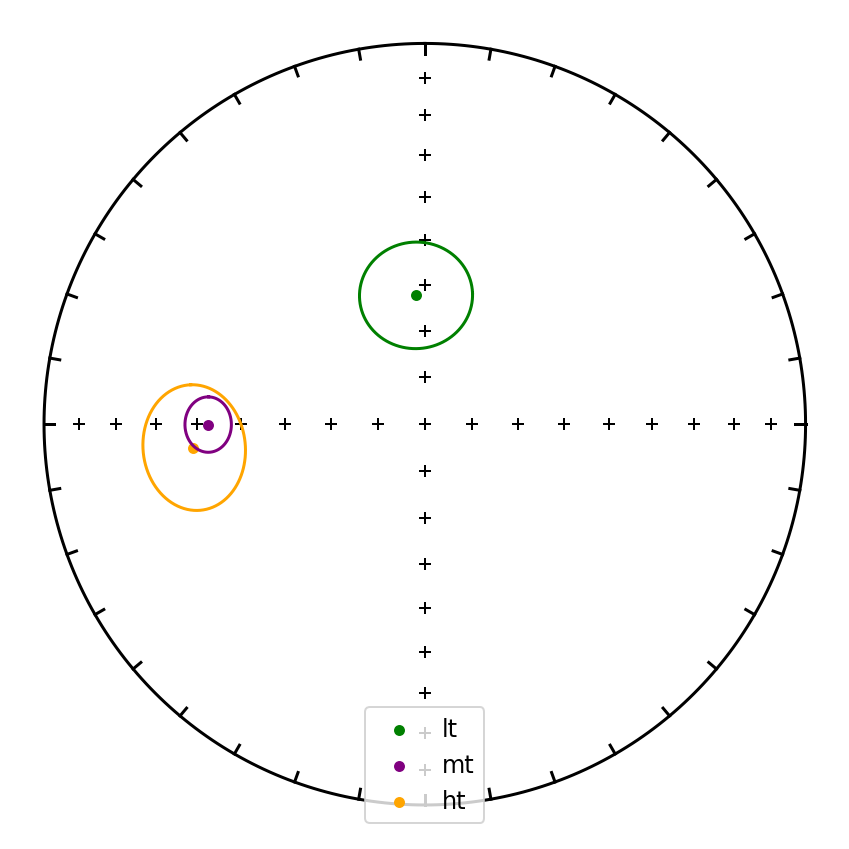

In [42]:
plt.figure(figsize=(6,6))
ipmag.plot_net()
ipmag.plot_di_mean(CB7_site_data_lt_gc.dir_dec.tolist()[0], 
                   CB7_site_data_lt_gc.dir_inc.tolist()[0], 
                   CB7_site_data_lt_gc.dir_alpha95.tolist()[0], 
                   color='green', label='lt')
ipmag.plot_di_mean(CB7_site_data_mt_tc.dir_dec.tolist()[0], 
                   CB7_site_data_mt_tc.dir_inc.tolist()[0], 
                   CB7_site_data_mt_tc.dir_alpha95.tolist()[0], 
                   color='purple', label='mt')
ipmag.plot_di_mean(CB7_site_data_ht_tc.dir_dec.tolist()[0], 
                   CB7_site_data_ht_tc.dir_inc.tolist()[0], 
                   CB7_site_data_ht_tc.dir_alpha95.tolist()[0], 
                   color='orange', label='ht')

plt.legend(loc=8, fontsize=12)
plt.show()

#### Lava Chuar summary

combining CB6-CB7 site data

In [44]:
CB_Lava_Chuar_mt_tc = CB_site_data_mt_tc[CB_site_data_mt_tc['site'].isin(['CB6','CB7'])]

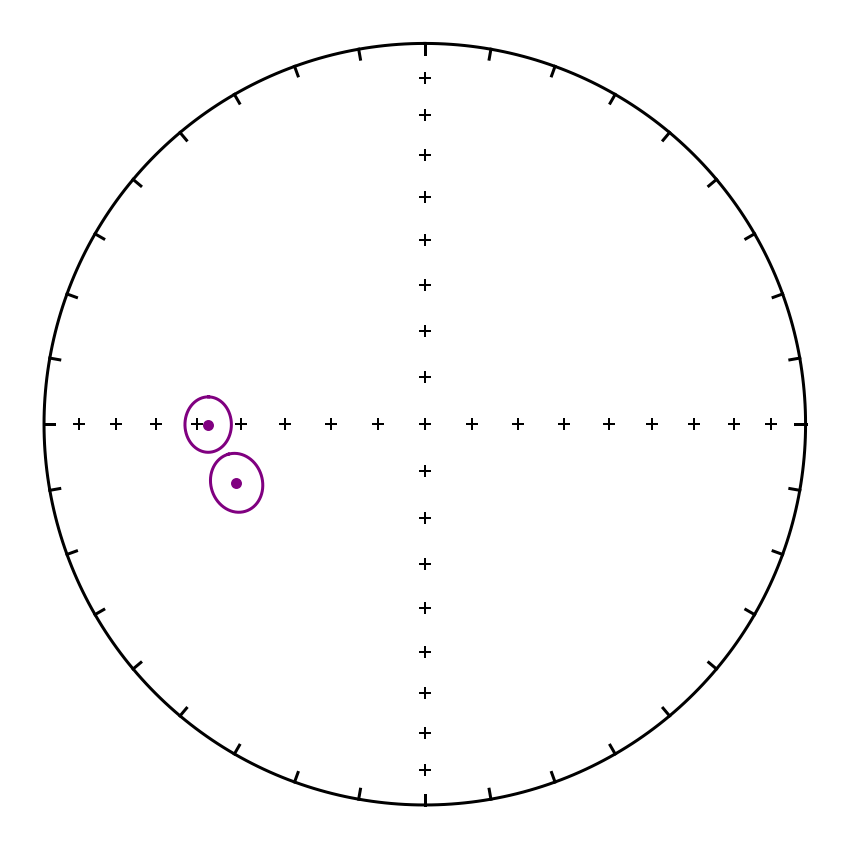

In [45]:
plt.figure(figsize=(6,6))
ipmag.plot_net()
for i in range(CB_Lava_Chuar_mt_tc.shape[0]):
    ipmag.plot_di_mean(CB_Lava_Chuar_mt_tc['dir_dec'].tolist()[i], 
                     CB_Lava_Chuar_mt_tc['dir_inc'].tolist()[i], 
                     CB_Lava_Chuar_mt_tc['dir_alpha95'].tolist()[i],
                     color = 'purple')

# plt.legend()
plt.show()

### Cardenas Basalts at Basalt Canyon

site CB8-18 and CBS1 are collected form river mile 70 Basalt Canyon. 

In [27]:
CB_Basalt_Canyon_mt_tc = CB_site_data_mt_tc[~CB_site_data_mt_tc['site'].isin(['CB1','CB2','CB3','CB4','CB5','CB6','CB7'])]

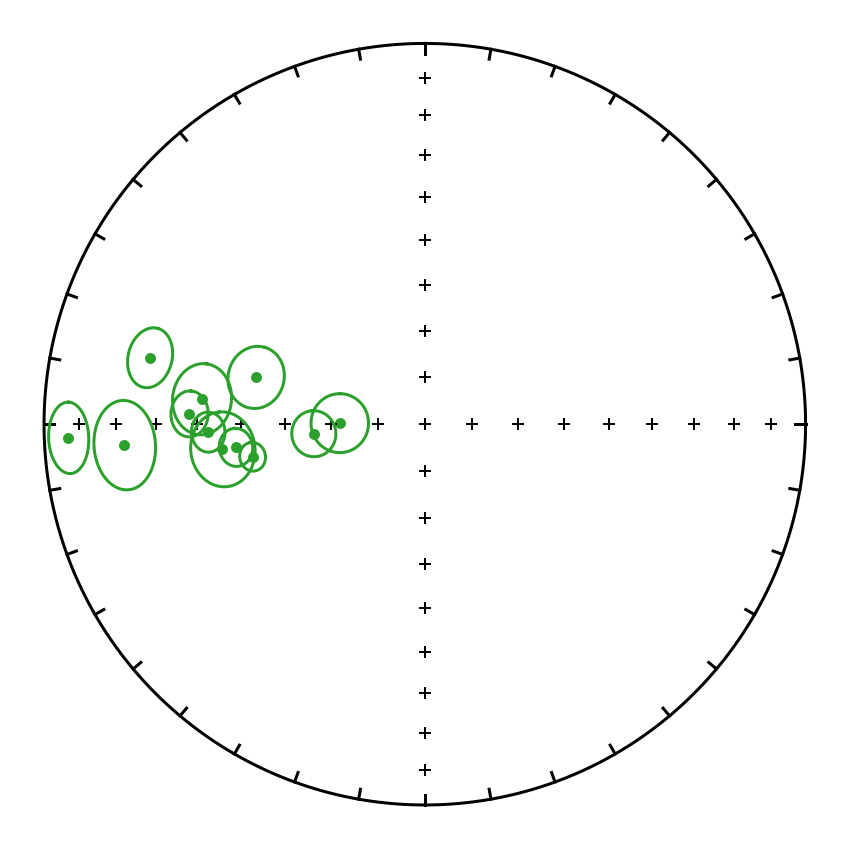

In [28]:
plt.figure(figsize=(6,6))
ipmag.plot_net()
for i in range(CB_Basalt_Canyon_mt_tc.shape[0]):
    ipmag.plot_di_mean(CB_Basalt_Canyon_mt_tc['dir_dec'].tolist()[i], 
                     CB_Basalt_Canyon_mt_tc['dir_inc'].tolist()[i], 
                     CB_Basalt_Canyon_mt_tc['dir_alpha95'].tolist()[i],
                     color = 'C2')

# plt.legend()
plt.show()

<Figure size 432x432 with 0 Axes>

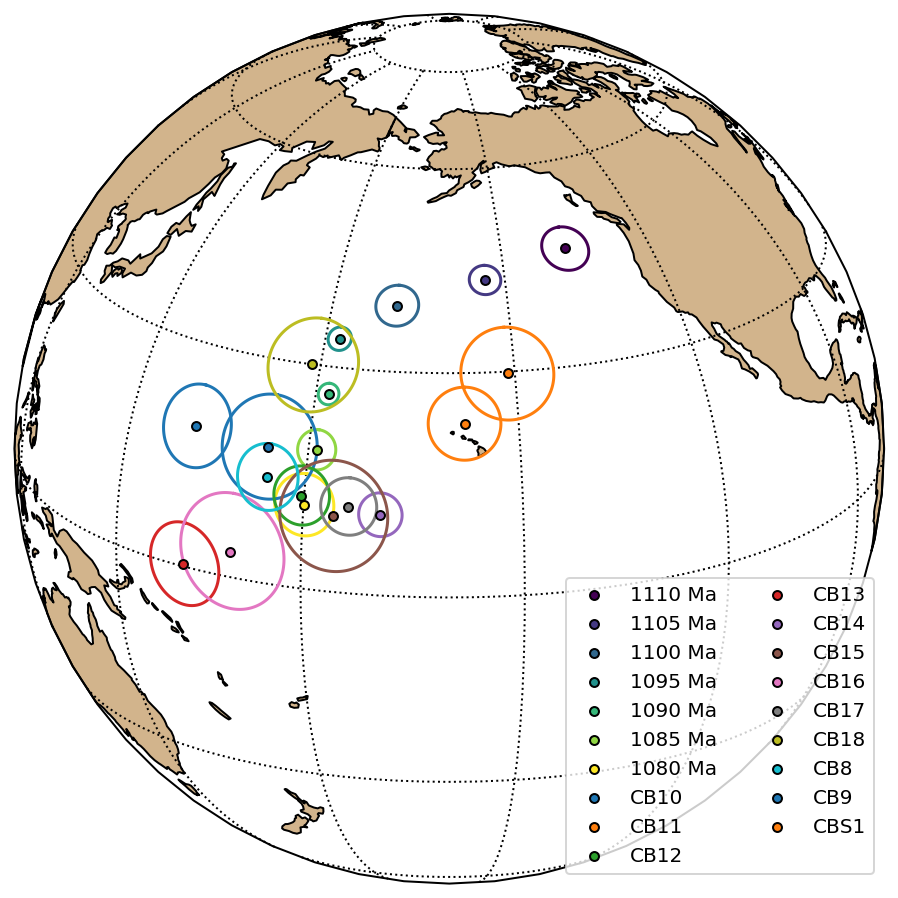

In [29]:
plt.figure(figsize = (6,6))
m = ipmag.make_orthographic_map(central_longitude=200, central_latitude=20)

synthetic_ages = [1080, 1085, 1090, 1095, 1100, 1105, 1110]
cNorm  = colors.Normalize(vmin=min(synthetic_ages), vmax=max(synthetic_ages))
scalarMap = matplotlib.cm.ScalarMappable(norm=cNorm, cmap='viridis')

synthetic_colors = [colors.rgb2hex(scalarMap.to_rgba(synthetic_ages[i])) for i in range(len(synthetic_ages))]

one_Euler_pole_lon = np.loadtxt('../data/mcplates_results/pole_lon_positions_2_true.txt')
one_Euler_pole_lat = np.loadtxt('../data/mcplates_results/pole_lat_positions_2_true.txt')

fisher0 = ipmag.fisher_mean(one_Euler_pole_lon[:,0]+180,one_Euler_pole_lat[:,0])
theta0 = ipmag.fisher_angular_deviation(one_Euler_pole_lon[:,0]+180,one_Euler_pole_lat[:,0])
fisher0['theta'] = theta0
ipmag.plot_pole(m,fisher0['dec'],fisher0['inc'],theta0,color=synthetic_colors[0],label='1110 Ma')

fisher1 = ipmag.fisher_mean(one_Euler_pole_lon[:,1]+180,one_Euler_pole_lat[:,1])
theta1 = ipmag.fisher_angular_deviation(one_Euler_pole_lon[:,1]+180,one_Euler_pole_lat[:,1])
fisher1['theta'] = theta1
ipmag.plot_pole(m,fisher1['dec'],fisher1['inc'],theta1,color=synthetic_colors[1],label='1105 Ma')

fisher2 = ipmag.fisher_mean(one_Euler_pole_lon[:,2]+180,one_Euler_pole_lat[:,2])
theta2 = ipmag.fisher_angular_deviation(one_Euler_pole_lon[:,2]+180,one_Euler_pole_lat[:,2])
fisher2['theta'] = theta2
ipmag.plot_pole(m,fisher2['dec'],fisher2['inc'],theta2,color=synthetic_colors[2],label='1100 Ma')

fisher3 = ipmag.fisher_mean(one_Euler_pole_lon[:,3]+180,one_Euler_pole_lat[:,3])
theta3 = ipmag.fisher_angular_deviation(one_Euler_pole_lon[:,3]+180,one_Euler_pole_lat[:,3])
fisher3['theta'] = theta3
ipmag.plot_pole(m,fisher3['dec'],fisher3['inc'],theta3,color=synthetic_colors[3],label='1095 Ma')

fisher4 = ipmag.fisher_mean(one_Euler_pole_lon[:,4]+180,one_Euler_pole_lat[:,4])
theta4 = ipmag.fisher_angular_deviation(one_Euler_pole_lon[:,4]+180,one_Euler_pole_lat[:,4])
fisher4['theta'] = theta4
ipmag.plot_pole(m,fisher4['dec'],fisher4['inc'],theta4,color=synthetic_colors[4],label='1090 Ma')

fisher5 = ipmag.fisher_mean(one_Euler_pole_lon[:,5]+180,one_Euler_pole_lat[:,5])
theta5 = ipmag.fisher_angular_deviation(one_Euler_pole_lon[:,5]+180,one_Euler_pole_lat[:,5])
fisher5['theta'] = theta5
ipmag.plot_pole(m,fisher5['dec'],fisher5['inc'],theta5,color=synthetic_colors[5],label='1085 Ma')

fisher6 = ipmag.fisher_mean(one_Euler_pole_lon[:,6]+180,one_Euler_pole_lat[:,6])
theta6 = ipmag.fisher_angular_deviation(one_Euler_pole_lon[:,6]+180,one_Euler_pole_lat[:,6])
fisher6['theta'] = theta6
ipmag.plot_pole(m,fisher6['dec'],fisher6['inc'],theta6,color=synthetic_colors[6],label='1080 Ma')

for i in range(CB_Basalt_Canyon_mt_tc.shape[0]):
    ipmag.plot_pole(m, CB_Basalt_Canyon_mt_tc['vgp_lon'].tolist()[i], 
                     CB_Basalt_Canyon_mt_tc['vgp_lat'].tolist()[i], 
                     CB_Basalt_Canyon_mt_tc['dir_alpha95'].tolist()[i],
                     color = 'C'+str(i), label = CB_Basalt_Canyon_mt_tc['site'].tolist()[i])


plt.legend(ncol=2)
plt.show()

## plot combined 1080 units (interpreted) pole position

In [30]:
Cardenas_all =  pd.concat([CB_Nankoweap_mt_tc, CB_Lava_Chuar_mt_tc, CB_Basalt_Canyon_mt_tc])
Cardenas_all = Cardenas_all[~Cardenas_all['site'].str.contains('CBS')]
Cardenas_all_mean_pole = ipmag.fisher_mean(Cardenas_all['vgp_lon'].tolist(), Cardenas_all['vgp_lat'].tolist())
Cardenas_all_mean_pole

{'dec': 184.59372164828602,
 'inc': 16.35368757511877,
 'n': 18,
 'r': 17.24237079918689,
 'k': 22.43841708022223,
 'alpha95': 7.461310830847244,
 'csd': 17.099716520757973}

<Figure size 432x432 with 0 Axes>

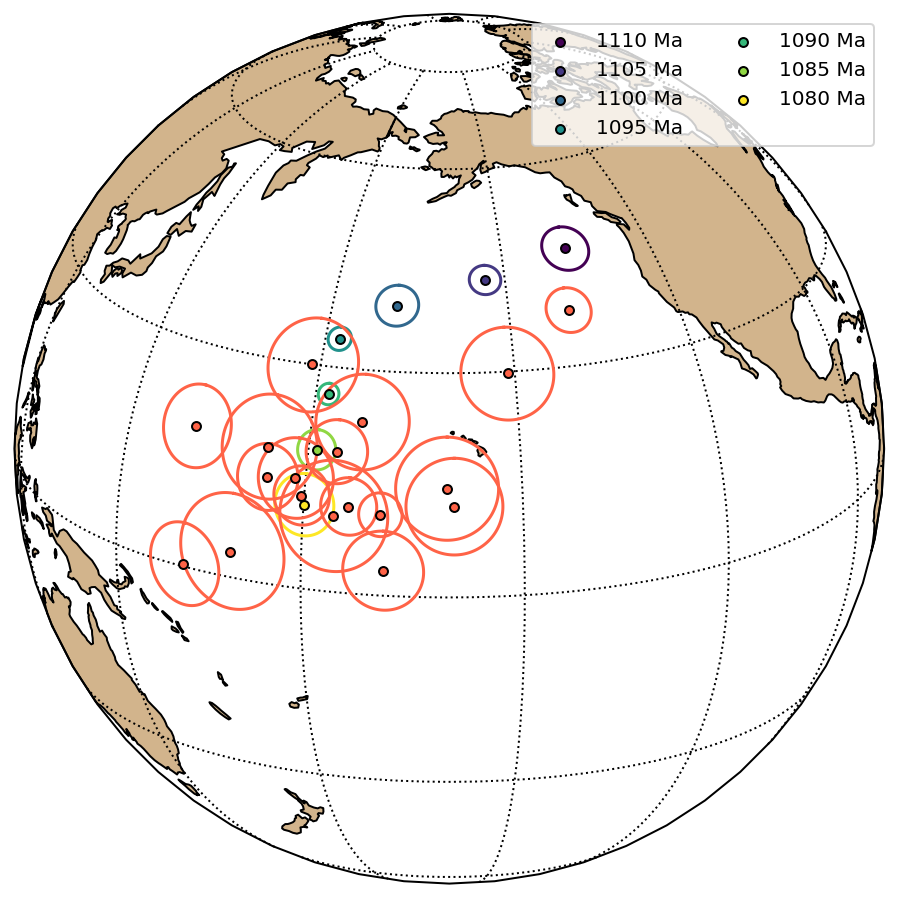

In [31]:
plt.figure(figsize = (6,6))
m = ipmag.make_orthographic_map(central_longitude=200, central_latitude=20)

synthetic_ages = [1080, 1085, 1090, 1095, 1100, 1105, 1110]
cNorm  = colors.Normalize(vmin=min(synthetic_ages), vmax=max(synthetic_ages))
scalarMap = matplotlib.cm.ScalarMappable(norm=cNorm, cmap='viridis')

synthetic_colors = [colors.rgb2hex(scalarMap.to_rgba(synthetic_ages[i])) for i in range(len(synthetic_ages))]

one_Euler_pole_lon = np.loadtxt('../data/mcplates_results/pole_lon_positions_2_true.txt')
one_Euler_pole_lat = np.loadtxt('../data/mcplates_results/pole_lat_positions_2_true.txt')

fisher0 = ipmag.fisher_mean(one_Euler_pole_lon[:,0]+180,one_Euler_pole_lat[:,0])
theta0 = ipmag.fisher_angular_deviation(one_Euler_pole_lon[:,0]+180,one_Euler_pole_lat[:,0])
fisher0['theta'] = theta0
ipmag.plot_pole(m,fisher0['dec'],fisher0['inc'],theta0,color=synthetic_colors[0],label='1110 Ma')

fisher1 = ipmag.fisher_mean(one_Euler_pole_lon[:,1]+180,one_Euler_pole_lat[:,1])
theta1 = ipmag.fisher_angular_deviation(one_Euler_pole_lon[:,1]+180,one_Euler_pole_lat[:,1])
fisher1['theta'] = theta1
ipmag.plot_pole(m,fisher1['dec'],fisher1['inc'],theta1,color=synthetic_colors[1],label='1105 Ma')

fisher2 = ipmag.fisher_mean(one_Euler_pole_lon[:,2]+180,one_Euler_pole_lat[:,2])
theta2 = ipmag.fisher_angular_deviation(one_Euler_pole_lon[:,2]+180,one_Euler_pole_lat[:,2])
fisher2['theta'] = theta2
ipmag.plot_pole(m,fisher2['dec'],fisher2['inc'],theta2,color=synthetic_colors[2],label='1100 Ma')

fisher3 = ipmag.fisher_mean(one_Euler_pole_lon[:,3]+180,one_Euler_pole_lat[:,3])
theta3 = ipmag.fisher_angular_deviation(one_Euler_pole_lon[:,3]+180,one_Euler_pole_lat[:,3])
fisher3['theta'] = theta3
ipmag.plot_pole(m,fisher3['dec'],fisher3['inc'],theta3,color=synthetic_colors[3],label='1095 Ma')

fisher4 = ipmag.fisher_mean(one_Euler_pole_lon[:,4]+180,one_Euler_pole_lat[:,4])
theta4 = ipmag.fisher_angular_deviation(one_Euler_pole_lon[:,4]+180,one_Euler_pole_lat[:,4])
fisher4['theta'] = theta4
ipmag.plot_pole(m,fisher4['dec'],fisher4['inc'],theta4,color=synthetic_colors[4],label='1090 Ma')

fisher5 = ipmag.fisher_mean(one_Euler_pole_lon[:,5]+180,one_Euler_pole_lat[:,5])
theta5 = ipmag.fisher_angular_deviation(one_Euler_pole_lon[:,5]+180,one_Euler_pole_lat[:,5])
fisher5['theta'] = theta5
ipmag.plot_pole(m,fisher5['dec'],fisher5['inc'],theta5,color=synthetic_colors[5],label='1085 Ma')

fisher6 = ipmag.fisher_mean(one_Euler_pole_lon[:,6]+180,one_Euler_pole_lat[:,6])
theta6 = ipmag.fisher_angular_deviation(one_Euler_pole_lon[:,6]+180,one_Euler_pole_lat[:,6])
fisher6['theta'] = theta6
ipmag.plot_pole(m,fisher6['dec'],fisher6['inc'],theta6,color=synthetic_colors[6],label='1080 Ma')

ipmag.plot_poles(m, Cardenas_all['vgp_lon'].tolist(), Cardenas_all['vgp_lat'].tolist(), Cardenas_all['dir_alpha95'].tolist(), color = 'tomato')


plt.legend(ncol=2)
plt.show()

<Figure size 432x432 with 0 Axes>

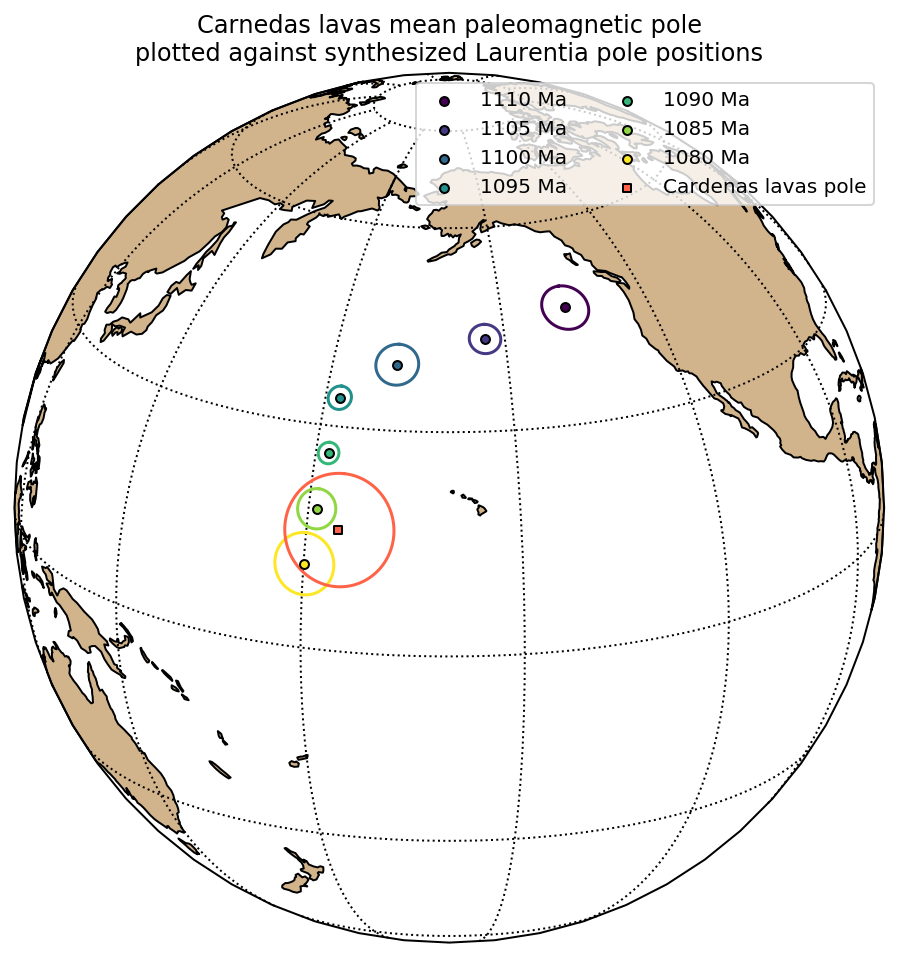

In [32]:
plt.figure(figsize = (6,6))
m = ipmag.make_orthographic_map(central_longitude=200, central_latitude=20)

synthetic_ages = [1080, 1085, 1090, 1095, 1100, 1105, 1110]
cNorm  = colors.Normalize(vmin=min(synthetic_ages), vmax=max(synthetic_ages))
scalarMap = matplotlib.cm.ScalarMappable(norm=cNorm, cmap='viridis')

synthetic_colors = [colors.rgb2hex(scalarMap.to_rgba(synthetic_ages[i])) for i in range(len(synthetic_ages))]

one_Euler_pole_lon = np.loadtxt('../data/mcplates_results/pole_lon_positions_2_true.txt')
one_Euler_pole_lat = np.loadtxt('../data/mcplates_results/pole_lat_positions_2_true.txt')

fisher0 = ipmag.fisher_mean(one_Euler_pole_lon[:,0]+180,one_Euler_pole_lat[:,0])
theta0 = ipmag.fisher_angular_deviation(one_Euler_pole_lon[:,0]+180,one_Euler_pole_lat[:,0])
fisher0['theta'] = theta0
ipmag.plot_pole(m,fisher0['dec'],fisher0['inc'],theta0,color=synthetic_colors[0],label='1110 Ma')

fisher1 = ipmag.fisher_mean(one_Euler_pole_lon[:,1]+180,one_Euler_pole_lat[:,1])
theta1 = ipmag.fisher_angular_deviation(one_Euler_pole_lon[:,1]+180,one_Euler_pole_lat[:,1])
fisher1['theta'] = theta1
ipmag.plot_pole(m,fisher1['dec'],fisher1['inc'],theta1,color=synthetic_colors[1],label='1105 Ma')

fisher2 = ipmag.fisher_mean(one_Euler_pole_lon[:,2]+180,one_Euler_pole_lat[:,2])
theta2 = ipmag.fisher_angular_deviation(one_Euler_pole_lon[:,2]+180,one_Euler_pole_lat[:,2])
fisher2['theta'] = theta2
ipmag.plot_pole(m,fisher2['dec'],fisher2['inc'],theta2,color=synthetic_colors[2],label='1100 Ma')

fisher3 = ipmag.fisher_mean(one_Euler_pole_lon[:,3]+180,one_Euler_pole_lat[:,3])
theta3 = ipmag.fisher_angular_deviation(one_Euler_pole_lon[:,3]+180,one_Euler_pole_lat[:,3])
fisher3['theta'] = theta3
ipmag.plot_pole(m,fisher3['dec'],fisher3['inc'],theta3,color=synthetic_colors[3],label='1095 Ma')

fisher4 = ipmag.fisher_mean(one_Euler_pole_lon[:,4]+180,one_Euler_pole_lat[:,4])
theta4 = ipmag.fisher_angular_deviation(one_Euler_pole_lon[:,4]+180,one_Euler_pole_lat[:,4])
fisher4['theta'] = theta4
ipmag.plot_pole(m,fisher4['dec'],fisher4['inc'],theta4,color=synthetic_colors[4],label='1090 Ma')

fisher5 = ipmag.fisher_mean(one_Euler_pole_lon[:,5]+180,one_Euler_pole_lat[:,5])
theta5 = ipmag.fisher_angular_deviation(one_Euler_pole_lon[:,5]+180,one_Euler_pole_lat[:,5])
fisher5['theta'] = theta5
ipmag.plot_pole(m,fisher5['dec'],fisher5['inc'],theta5,color=synthetic_colors[5],label='1085 Ma')

fisher6 = ipmag.fisher_mean(one_Euler_pole_lon[:,6]+180,one_Euler_pole_lat[:,6])
theta6 = ipmag.fisher_angular_deviation(one_Euler_pole_lon[:,6]+180,one_Euler_pole_lat[:,6])
fisher6['theta'] = theta6
ipmag.plot_pole(m,fisher6['dec'],fisher6['inc'],theta6,color=synthetic_colors[6],label='1080 Ma')

ipmag.plot_pole(m, Cardenas_all_mean_pole['dec'], Cardenas_all_mean_pole['inc'], Cardenas_all_mean_pole['alpha95'], marker = 's', color = 'tomato', label='Cardenas lavas pole')

plt.title('Carnedas lavas mean paleomagnetic pole\nplotted against synthesized Laurentia pole positions')
plt.legend(ncol=2)
# plt.savefig('../Figure/Cardenas_pole.pdf', bbox_inches='tight')
plt.show()

## Applying Bryan 1986 Colorado plateau rotation 

3.9 (1.4-6.6 95% confidence interval) CW rotation of the plateau around Euler pole of 37N, 103W

In [33]:
units_1080_mean_pole_lat_rot, units_1080_mean_pole_lon_rot = pmag.pt_rot([37, -103, 3.9], [units_1080_mean_pole['inc']], [units_1080_mean_pole['dec']])
units_1080_mean_pole_lat_rot, units_1080_mean_pole_lon_rot

NameError: name 'units_1080_mean_pole' is not defined

In [ ]:
plt.figure(figsize = (6,6))
m = ipmag.make_orthographic_map(central_longitude=200, central_latitude=20)

synthetic_ages = [1080, 1085, 1090, 1095, 1100, 1105, 1110]
cNorm  = colors.Normalize(vmin=min(synthetic_ages), vmax=max(synthetic_ages))
scalarMap = matplotlib.cm.ScalarMappable(norm=cNorm, cmap='viridis')

synthetic_colors = [colors.rgb2hex(scalarMap.to_rgba(synthetic_ages[i])) for i in range(len(synthetic_ages))]

one_Euler_pole_lon = np.loadtxt('../data/mcplates_results/pole_lon_positions_2_true.txt')
one_Euler_pole_lat = np.loadtxt('../data/mcplates_results/pole_lat_positions_2_true.txt')

fisher0 = ipmag.fisher_mean(one_Euler_pole_lon[:,0]+180,one_Euler_pole_lat[:,0])
theta0 = ipmag.fisher_angular_deviation(one_Euler_pole_lon[:,0]+180,one_Euler_pole_lat[:,0])
fisher0['theta'] = theta0
ipmag.plot_pole(m,fisher0['dec'],fisher0['inc'],theta0,color=synthetic_colors[0],label='1110 Ma')

fisher1 = ipmag.fisher_mean(one_Euler_pole_lon[:,1]+180,one_Euler_pole_lat[:,1])
theta1 = ipmag.fisher_angular_deviation(one_Euler_pole_lon[:,1]+180,one_Euler_pole_lat[:,1])
fisher1['theta'] = theta1
ipmag.plot_pole(m,fisher1['dec'],fisher1['inc'],theta1,color=synthetic_colors[1],label='1105 Ma')

fisher2 = ipmag.fisher_mean(one_Euler_pole_lon[:,2]+180,one_Euler_pole_lat[:,2])
theta2 = ipmag.fisher_angular_deviation(one_Euler_pole_lon[:,2]+180,one_Euler_pole_lat[:,2])
fisher2['theta'] = theta2
ipmag.plot_pole(m,fisher2['dec'],fisher2['inc'],theta2,color=synthetic_colors[2],label='1100 Ma')

fisher3 = ipmag.fisher_mean(one_Euler_pole_lon[:,3]+180,one_Euler_pole_lat[:,3])
theta3 = ipmag.fisher_angular_deviation(one_Euler_pole_lon[:,3]+180,one_Euler_pole_lat[:,3])
fisher3['theta'] = theta3
ipmag.plot_pole(m,fisher3['dec'],fisher3['inc'],theta3,color=synthetic_colors[3],label='1095 Ma')

fisher4 = ipmag.fisher_mean(one_Euler_pole_lon[:,4]+180,one_Euler_pole_lat[:,4])
theta4 = ipmag.fisher_angular_deviation(one_Euler_pole_lon[:,4]+180,one_Euler_pole_lat[:,4])
fisher4['theta'] = theta4
ipmag.plot_pole(m,fisher4['dec'],fisher4['inc'],theta4,color=synthetic_colors[4],label='1090 Ma')

fisher5 = ipmag.fisher_mean(one_Euler_pole_lon[:,5]+180,one_Euler_pole_lat[:,5])
theta5 = ipmag.fisher_angular_deviation(one_Euler_pole_lon[:,5]+180,one_Euler_pole_lat[:,5])
fisher5['theta'] = theta5
ipmag.plot_pole(m,fisher5['dec'],fisher5['inc'],theta5,color=synthetic_colors[5],label='1085 Ma')

fisher6 = ipmag.fisher_mean(one_Euler_pole_lon[:,6]+180,one_Euler_pole_lat[:,6])
theta6 = ipmag.fisher_angular_deviation(one_Euler_pole_lon[:,6]+180,one_Euler_pole_lat[:,6])
fisher6['theta'] = theta6
ipmag.plot_pole(m,fisher6['dec'],fisher6['inc'],theta6,color=synthetic_colors[6],label='1080 Ma')

# ipmag.plot_pole(m, units_1080_mean_pole['dec'], units_1080_mean_pole['inc'], units_1080_mean_pole['alpha95'], marker = 's', color = 'tomato', label='Grand Canyon pole')
ipmag.plot_pole(m, units_1080_mean_pole_lon_rot[0], units_1080_mean_pole_lat_rot[0], units_1080_mean_pole['alpha95'], marker = 's', color = 'dodgerblue', label='Cardenas pole')



plt.legend(ncol=2)
# plt.savefig('../Figure/Cardenas_pole_rotated.pdf')
plt.show()